In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from sklearn.utils import resample
import scipy.stats as st 

# Guntzer Algo

In [2]:
# LNNCP initial ba
def lnncp_function(daily_payments):
    
    # get unique members
    members = np.unique([daily_payments.sender, daily_payments.receiver])
        
    lnncp_dict = {}
    
    # for each members
    for member in members:
        
        # get their payments sent and received
        df_payments = daily_payments.loc[(daily_payments.sender == member)|
                                         (daily_payments.receiver == member)]
                
        # if no payments, then set their LNNCP to 0
        if df_payments.shape[0] == 0:
            lnncp_dict[member] = daily_payments.time.iloc[0].replace(
                hour = 0, minute = 0, second = 0), 0, 0
            continue
    
        # set sent payments as negative
        to_cumulate = df_payments.apply(lambda x: x.value*(-1) 
                                        if x.sender == member 
                                        else x.value, axis=1)
        
        # do the cumulative sum of payments sent and received (this gives the balance at each row)
        liquidity_series = to_cumulate.cumsum().set_axis(df_payments.time)
        
        # get the min of the balance (= LNNCP)
        lnncp_value = liquidity_series.min()
        lnncp_value = min(lnncp_value, 0.0)
        
        # get the time at which the minimum was reached
        min_datetime = to_cumulate.cumsum().set_axis(df_payments.time).idxmin()
        
        # get the total value to be cleared
        gross_cleared = daily_payments.loc[(daily_payments.sender == member)].value.sum()
        
        lnncp_dict[member] = min_datetime, lnncp_value, gross_cleared
    
    lnncp_df = pd.DataFrame.from_dict(lnncp_dict, orient='index', columns=['time','lnncp','value_cleared'])   
    return lnncp_df

In [3]:
class Guntzer:
    # calculates deficits
    def Deficit(self,participant,df,d):
        return d[participant] + np.sum(df[df['receiver']==participant]['value']*df[df['receiver']==participant]['x'])\
                - np.sum(df[df['sender']==participant]['value']*df[df['sender']==participant]['x'])

    def __init__(self, df, init_balance):
        self.df = df
        self.df['x'] = np.ones(len(df)) # a payment is active if its x value == 1
        self.participants = np.unique([df.sender, df.receiver])
        self.N = len(self.participants)
        self.init_balance = init_balance
        deficits = {}
        for x in self.participants:
            deficits[x] = self.Deficit(x,df,init_balance)
        self.deficits =  pd.Series(deficits)
        postop = {key: True for key in self.participants}
        self.postop = pd.Series(postop)

    # multilateral optimization
    def optimize(self):
        deficits = self.deficits
        df = self.df
        while deficits.min()<0:
            # find the current bank
            current_bank = deficits.idxmin()

            # find payments where the current bank recieves an inactive payment whose value is less than the sender's deficit
            temp = df[(df['receiver'] == current_bank) & (df['x']==0) & (df['value'] <= df['sender'].apply(lambda x: deficits[x]))]

            # while the current bank has a deficit and such a payment exists
            while (len(temp)) and (deficits[current_bank] < 0):
                temp = temp.sort_values(by='value', ascending=True)
                filtered = temp[temp['value']>= -deficits[current_bank]]
                if len(filtered):
                    found = filtered.index[0]
                    value = filtered.iloc[0]['value']
                    sender = filtered.iloc[0]['sender']
                    df.loc[found, 'x'] = 1
                    deficits[sender] -= value
                    deficits[current_bank] += value
                else:
                    found = temp.index[-1]
                    value = temp.iloc[-1]['value']
                    sender = temp.iloc[-1]['sender']
                    df.loc[found, 'x'] = 1
                    deficits[sender] -= value
                    deficits[current_bank] += value
                temp = df[(df['receiver'] == current_bank) & (df['x']==0) & (df['value'] <= df['sender'].apply(lambda x: deficits[x]))]

            # find payments where the current bank sends an active payment whose value is less than the receiver's deficit
            temp = df[(df['sender'] == current_bank) & (df['x']==1) & (df['value'] <= df['receiver'].apply(lambda x: deficits[x]))]

            # while the current bank has a deficit and such a payment exists
            while (len(temp)) and (deficits[current_bank] < 0):
                temp = temp.sort_values(by='value', ascending=True)
                filtered = temp[temp['value'] >= -deficits[current_bank]]
                if len(filtered):
                    found = filtered.index[0]
                    value = filtered.iloc[0]['value']
                    receiver = filtered.iloc[0]['receiver']
                    df.loc[found, 'x'] = 0
                    deficits[receiver] -= value
                    deficits[current_bank] += value
                else:
                    found = temp.index[-1]
                    value = temp.iloc[-1]['value']
                    receiver = temp.iloc[-1]['receiver']
                    df.loc[found, 'x'] = 0
                    deficits[receiver] -= value
                    deficits[current_bank] += value

                temp = df[(df['sender'] == current_bank) & (df['x']==1) & (df['value'] <= df['receiver'].apply(lambda x: deficits[x]))]

            # find payments where the current bank sends an active payment whose value is greater than the deficit of the current bank
            while deficits[current_bank] < 0:
                temp = df[(df['sender'] == current_bank) & (df['x']==1)]
                temp = temp.sort_values(by='value', ascending=True)
                filtered =  temp[temp['value'] >= -deficits[current_bank]]
                if len(filtered):
                    found = filtered.index[0]
                    value = filtered.iloc[0]['value']
                    receiver = filtered.iloc[0]['receiver']
                    df.loc[found, 'x'] = 0
                    deficits[receiver] -= value
                    deficits[current_bank] += value
                elif len(temp):
                    found = temp.index[-1]
                    value = temp.iloc[-1]['value']
                    receiver = temp.iloc[-1]['receiver']
                    df.loc[found, 'x'] = 0
                    deficits[receiver] -= value
                    deficits[current_bank] += value
                else:
                    print(current_bank, " requires more balance")
                    break
        self.deficits = deficits
        self.df = df
        
    # post optimization
    def post_optimize(self):
        postop = self.postop
        df = self.df
        deficits = self.deficits
        postop_filt = postop[postop==True]

        while len(postop_filt):
            for part in self.participants:
                temp = df[(df['sender']==part) & (df['x']==0)]
                temp = temp.sort_values(by='value', ascending=False)
                if len(temp):
                    for index, row in temp.iterrows():
                        if row['value'] <= deficits[part]:
                            df.loc[index, 'x'] = 1
#                             print('activated payment from', part, 'to', row['receiver'])
                            deficits[part] -= row['value']
                            deficits[row['receiver']] += row['value']
                            postop.loc[row['receiver']] = True
                postop.loc[part] = False
            postop_filt = postop[postop==True]

        self.df = df
        self.deficits = deficits

    # prints details about the optimization process
    def result(self):
        df = self.df
        print(len(df[df['x']==0]), 'payments out of', len(df), 'were inactivated')
        print(len(df[df['x']==1])/len(df)*100, '% payments were active')
        print(df[df['x']==1]['value'].sum(), 'out of', df['value'].sum(), 'was the total amount cleared')
        print(df[df['x']==1]['value'].sum()/ df['value'].sum()*100, '% values were cleared')
        
    def liquidity_needed(self):
        liquidity = {}
        df = self.df
        for participant in self.participants:
            liquidity[participant] = np.sum(df[df['receiver']==participant]['value']*df[df['receiver']==participant]['x'])\
                                     - np.sum(df[df['sender']==participant]['value']*df[df['sender']==participant]['x'])
            if liquidity[participant] > 0:
                liquidity[participant] = 0
        return sum(liquidity.values())

    def total_volume_cleared(self):
        return self.df[self.df['x']==1]['value'].count()

    def total_amount_cleared(self):
        return self.df[self.df['x']==1]['value'].sum()
    
    def total_volume_queue(self):
        return self.df['value'].count()

    def total_amount_queue(self):
        return self.df['value'].sum()

In [4]:
def test_Guntzer(df, batch_size, lamb = 1):
    # lamb here is a coefficient of LNNCP
    value_cleared = []
    volume_cleared = []
    value_queue = []
    volume_queue = []
    running_time = []
    liquidity_needed = []
    
    # Shuffle the DataFrame randomly
    df_shuffled = df.sample(frac=1, random_state=1234)

    # Calculate the number of batches
    num_batches = len(df_shuffled) // batch_size

    # Split the shuffled DataFrame into batches
    batches = [df_shuffled.iloc[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    
    for i in tqdm(range(num_batches)):
        batch = pd.DataFrame(batches[i])
        batch['time'] = pd.to_datetime(batch['time'])
        batch = batch.sort_values(by='time', ascending=True)  
        initial_balance = lnncp_function(batch)
        initial_balance.reset_index(inplace=True)
        initial_balance['lnncp'] = -initial_balance['lnncp']
        initial_balance.rename({'index':'receiver','lnncp':'value'}, axis=1, inplace=True)

        participants = np.unique([batch.sender, batch.receiver])
        initial_balances = {key:0 for key in participants}
        for j, row in initial_balance.iterrows():
            initial_balances[row['receiver']] = row['value']
        modified_initial_balances = {key: value * lamb for key, value in initial_balances.items()}

        start_time = time.time()
        g1 = Guntzer(batch, modified_initial_balances)
        g1.optimize()
        g1.post_optimize()
        end_time = time.time()  # Record the end time
        
        # Calculate the results
        a = g1.total_volume_cleared()
        b = g1.total_amount_cleared()
        c = g1.total_volume_queue()
        d = g1.total_amount_queue()
        e = end_time - start_time
        f = g1.liquidity_needed()
        value_cleared.append(b)
        volume_cleared.append(a)
        value_queue.append(d)
        volume_queue.append(c)
        running_time.append(e)
        liquidity_needed.append(f)
    
    return value_cleared, volume_cleared, value_queue, volume_queue, running_time, liquidity_needed

In [5]:
# Run Guntzer for queue length 1000
df = pd.read_csv("payments.csv")

value_cleared_G_10_1000, volume_cleared_G_10_1000, value_queue_G_10_1000, volume_queue_G_10_1000, running_time_G_10_1000, liquidity_needed_G_10_1000 = test_Guntzer(df, 1000)
value_cleared_G_09_1000, volume_cleared_G_09_1000, value_queue_G_09_1000, volume_queue_G_09_1000, running_time_G_09_1000, liquidity_needed_G_09_1000 = test_Guntzer(df, 1000, lamb = 0.9)
value_cleared_G_08_1000, volume_cleared_G_08_1000, value_queue_G_08_1000, volume_queue_G_08_1000, running_time_G_08_1000, liquidity_needed_G_08_1000 = test_Guntzer(df, 1000, lamb = 0.8)
value_cleared_G_07_1000, volume_cleared_G_07_1000, value_queue_G_07_1000, volume_queue_G_07_1000, running_time_G_07_1000, liquidity_needed_G_07_1000 = test_Guntzer(df, 1000, lamb = 0.7)
value_cleared_G_06_1000, volume_cleared_G_06_1000, value_queue_G_06_1000, volume_queue_G_06_1000, running_time_G_06_1000, liquidity_needed_G_06_1000 = test_Guntzer(df, 1000, lamb = 0.6)
value_cleared_G_05_1000, volume_cleared_G_05_1000, value_queue_G_05_1000, volume_queue_G_05_1000, running_time_G_05_1000, liquidity_needed_G_05_1000 = test_Guntzer(df, 1000, lamb = 0.5)
value_cleared_G_03_1000, volume_cleared_G_03_1000, value_queue_G_03_1000, volume_queue_G_03_1000, running_time_G_03_1000, liquidity_needed_G_03_1000 = test_Guntzer(df, 1000, lamb = 0.3)

100%|██████████████████████████████████████████████████████████████████████████████| 1008/1008 [05:46<00:00,  2.91it/s]


# Bech Algo

In [6]:
# expost_balance takes a DataFrame called daily_payments, a String called participant, an DataFrame of containing
# initial balance called initial_balance and returns the balance of participant by including the initial balance
# expost_balance: DataFrame, Str, DataFrame -> Float
def expost_balance(daily_payments, participant, initial_balance):
    sent_payments = daily_payments[daily_payments['sender'] == participant]['value'].sum()
    received_payments = daily_payments[daily_payments['receiver'] == participant]['value'].sum()
    initial_received = initial_balance[initial_balance['receiver'] == participant]['value'].sum()
    balance = received_payments - sent_payments + initial_received
    return balance

# gridlock_resolution takes a DataFrame called daily_payments, a List of String of participants called participants, an DataFrame of 
# containing initial balance called initial_balance and a String called method, then returns the dataframe of gridlock solution
# gridlock_resolution: DataFrame, Listof Str, DataFrame, Str -> DataFrame
# Requires: method must be one of 'max value', 'max volume', 'min delay'
def gridlock_resolution(daily_payments, participants, initial_balance, method = 'max value'):

    if method == 'max value':
        daily_payments.sort_values('value',ascending=False,inplace=True)
    elif method == 'max volume':
        daily_payments.sort_values('value',ascending=True,inplace=True)
    elif method == 'min delay':
        daily_payments.sort_values('datetime',ascending=True,inplace=True)
    else:
        return 'Method input error.'

    # calculate balance of entire daily_payments
    balance = []
    balance = [expost_balance(daily_payments, member, initial_balance) for member in participants]
    balance_df = pd.DataFrame({'balance': balance}, index=participants)

    indicator = 1
    while(indicator):
        for member in participants:
            balance = balance_df.loc[member,'balance']
            if balance < 0:
                queue = daily_payments[daily_payments.sender == member]
                # base case if queue is empty
                if len(queue.index) == 0:
                    balance_df.loc[member,'balance'] = 0
                # otherwise remove last payment from queue
                else:
                    # find the last payment in queue
                    last_id = queue.index.values[-1]
                    sender_temp = queue.sender.values[-1]
                    receiver_temp = queue.receiver.values[-1]
                    value_temp = queue.value.values[-1]
                    # update balance in dataframe balance_df
                    balance_df.loc[sender_temp,'balance'] = balance_df.loc[sender_temp,'balance'] + value_temp
                    balance_df.loc[receiver_temp,'balance'] = balance_df.loc[receiver_temp,'balance'] - value_temp
                    # remove from the queue
                    daily_payments = daily_payments[daily_payments.index != last_id]
                break
            # if proceed to the last participant, end while loop
            elif member == participants[-1]:
                indicator = 0     
    return daily_payments

In [7]:
def test_Bech(df, batch_size, lamb = 1):
    # lamb here is a coefficient of LNNCP
    value_cleared = []
    volume_cleared = []
    value_queue = []
    volume_queue = []
    running_time = []
    liquidity_needed = []
    
    # Shuffle the DataFrame randomly
    df_shuffled = df.sample(frac=1, random_state=1234)

    # Calculate the number of batches
    num_batches = len(df_shuffled) // batch_size

    # Split the shuffled DataFrame into batches
    batches = [df_shuffled.iloc[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    
    for i in tqdm(range(num_batches)):
        batch = pd.DataFrame(batches[i])
        participants = np.unique([batch.sender, batch.receiver])
        batch_copy = batch.copy()
        batch['time'] = pd.to_datetime(batch['time'])
        batch = batch.sort_values(by='time', ascending=True)  
        initial_balance = lnncp_function(batch)
        initial_balance.reset_index(inplace=True)
        initial_balance['lnncp'] = -initial_balance['lnncp']
        initial_balance.rename({'index':'receiver','lnncp':'value'}, axis=1, inplace=True)
        initial_balance['value'] = initial_balance['value'] * lamb

        start_time = time.time()
        batch_new = gridlock_resolution(batch_copy, participants, initial_balance, method = 'max value')
        end_time = time.time()
        
        # Calculate the results
        a = batch_new.shape[0]
        b = batch_new['value'].sum()
        c = batch.shape[0]
        d = batch['value'].sum()
        e = end_time - start_time
        liquidity = {}
        for participant in participants:
            liquidity[participant] = np.sum(batch_new[batch_new['receiver']==participant]['value'])\
                                     - np.sum(batch_new[batch_new['sender']==participant]['value'])
            if liquidity[participant] > 0:
                liquidity[participant] = 0
        f = sum(liquidity.values())
        
        value_cleared.append(b)
        volume_cleared.append(a)
        value_queue.append(d)
        volume_queue.append(c)
        running_time.append(e)  
        liquidity_needed.append(f)
    
    return value_cleared, volume_cleared, value_queue, volume_queue, running_time, liquidity_needed

In [8]:
# Run Bech for queue length 1000
df = pd.read_csv("payments.csv")

value_cleared_B_10_1000, volume_cleared_B_10_1000, value_queue_B_10_1000, volume_queue_B_10_1000, running_time_B_10_1000, liquidity_needed_B_10_1000 = test_Bech(df, 1000)
value_cleared_B_09_1000, volume_cleared_B_09_1000, value_queue_B_09_1000, volume_queue_B_09_1000, running_time_B_09_1000, liquidity_needed_B_09_1000 = test_Bech(df, 1000, lamb = 0.9)
value_cleared_B_08_1000, volume_cleared_B_08_1000, value_queue_B_08_1000, volume_queue_B_08_1000, running_time_B_08_1000, liquidity_needed_B_08_1000 = test_Bech(df, 1000, lamb = 0.8)
value_cleared_B_07_1000, volume_cleared_B_07_1000, value_queue_B_07_1000, volume_queue_B_07_1000, running_time_B_07_1000, liquidity_needed_B_07_1000 = test_Bech(df, 1000, lamb = 0.7)
value_cleared_B_06_1000, volume_cleared_B_06_1000, value_queue_B_06_1000, volume_queue_B_06_1000, running_time_B_06_1000, liquidity_needed_B_06_1000 = test_Bech(df, 1000, lamb = 0.6)
value_cleared_B_05_1000, volume_cleared_B_05_1000, value_queue_B_05_1000, volume_queue_B_05_1000, running_time_B_05_1000, liquidity_needed_B_05_1000 = test_Bech(df, 1000, lamb = 0.5)
value_cleared_B_03_1000, volume_cleared_B_03_1000, value_queue_B_03_1000, volume_queue_B_03_1000, running_time_B_03_1000, liquidity_needed_B_03_1000 = test_Bech(df, 1000, lamb = 0.3)

100%|██████████████████████████████████████████████████████████████████████████████| 1008/1008 [03:10<00:00,  5.29it/s]


# Analysis

Using the payments file payments.csv in the Examination folder, generate queues of payments and compare statistically the performances of the two algorithms using the following variables for different initial balances and for different sizes of queue:
1. system liquidity need
2. total value cleared, total volume cleared
3. total value in the queue, total volume in the queue
4. computing time

Performances should be assessed over a large number of queues using averages and confidence intervals.

In [9]:
# Create a dataframe containing four measurements under different initial balances (queue length 1000)
list_of_lists = ['value_cleared_B_10_1000',  'volume_cleared_B_10_1000', 'running_time_B_10_1000', 'liquidity_needed_B_10_1000', \
                 'value_cleared_B_09_1000',  'volume_cleared_B_09_1000', 'running_time_B_09_1000', 'liquidity_needed_B_09_1000', \
                 'value_cleared_B_08_1000',  'volume_cleared_B_08_1000', 'running_time_B_08_1000', 'liquidity_needed_B_08_1000', \
                 'value_cleared_B_07_1000',  'volume_cleared_B_07_1000', 'running_time_B_07_1000', 'liquidity_needed_B_07_1000', \
                 'value_cleared_B_06_1000',  'volume_cleared_B_06_1000', 'running_time_B_06_1000', 'liquidity_needed_B_06_1000', \
                 'value_cleared_B_05_1000',  'volume_cleared_B_05_1000', 'running_time_B_05_1000', 'liquidity_needed_B_05_1000', \
                 'value_cleared_B_03_1000',  'volume_cleared_B_03_1000', 'running_time_B_03_1000', 'liquidity_needed_B_03_1000', \
                 'value_cleared_G_10_1000',  'volume_cleared_G_10_1000', 'running_time_G_10_1000', 'liquidity_needed_G_10_1000', \
                 'value_cleared_G_09_1000',  'volume_cleared_G_09_1000', 'running_time_G_09_1000', 'liquidity_needed_G_09_1000', \
                 'value_cleared_G_08_1000',  'volume_cleared_G_08_1000', 'running_time_G_08_1000', 'liquidity_needed_G_08_1000', \
                 'value_cleared_G_07_1000',  'volume_cleared_G_07_1000', 'running_time_G_07_1000', 'liquidity_needed_G_07_1000', \
                 'value_cleared_G_06_1000',  'volume_cleared_G_06_1000', 'running_time_G_06_1000', 'liquidity_needed_G_06_1000', \
                 'value_cleared_G_05_1000',  'volume_cleared_G_05_1000', 'running_time_G_05_1000', 'liquidity_needed_G_05_1000', \
                 'value_cleared_G_03_1000',  'volume_cleared_G_03_1000', 'running_time_G_03_1000', 'liquidity_needed_G_03_1000', \
                 'value_queue_G_10_1000',  'volume_queue_G_10_1000']
compare_data = {name: globals()[name] for name in list_of_lists}
compare_df = pd.DataFrame(compare_data)
compare_df.rename(columns={'value_queue_G_10_1000': 'value_queue', 'volume_queue_G_10_1000': 'volume_queue'}, inplace=True)
compare_df.head()

,value_cleared_B_10_1000,volume_cleared_B_10_1000,running_time_B_10_1000,liquidity_needed_B_10_1000,value_cleared_B_09_1000,volume_cleared_B_09_1000,running_time_B_09_1000,liquidity_needed_B_09_1000,value_cleared_B_08_1000,volume_cleared_B_08_1000,...,value_cleared_G_05_1000,volume_cleared_G_05_1000,running_time_G_05_1000,liquidity_needed_G_05_1000,value_cleared_G_03_1000,volume_cleared_G_03_1000,running_time_G_03_1000,liquidity_needed_G_03_1000,value_queue,volume_queue
0,1.924176e+09,1000,0.021529,-8.607057e+07,1.921096e+09,998,0.023051,-8.607057e+07,1.918728e+09,996,...,1.902235e+09,990,0.095903,-73563115.91,1.879110e+09,979,0.151663,-50108667.07,1.924176e+09,1000
1,1.933587e+09,1000,0.022727,-1.019227e+08,1.921744e+09,992,0.026521,-9.946904e+07,1.915829e+09,987,...,1.895681e+09,982,0.145032,-82918886.87,1.863554e+09,966,0.215179,-47733465.65,1.933587e+09,1000
2,1.926096e+09,1000,0.020390,-1.652357e+08,1.899855e+09,982,0.034130,-1.568342e+08,1.871163e+09,961,...,1.838167e+09,962,0.221227,-87831893.31,1.803019e+09,946,0.273598,-55773071.62,1.926096e+09,1000
3,1.930385e+09,1000,0.020890,-1.242696e+08,1.915883e+09,990,0.027006,-1.149615e+08,1.907847e+09,984,...,1.878359e+09,980,0.139029,-79356903.31,1.847216e+09,966,0.190244,-47816810.34,1.930385e+09,1000
4,1.950856e+09,999,0.024215,-9.256101e+07,1.940011e+09,993,0.028480,-8.762790e+07,1.940011e+09,993,...,1.927039e+09,986,0.149477,-81105692.22,1.897079e+09,972,0.228622,-55845144.64,1.952769e+09,1000


## Histograms

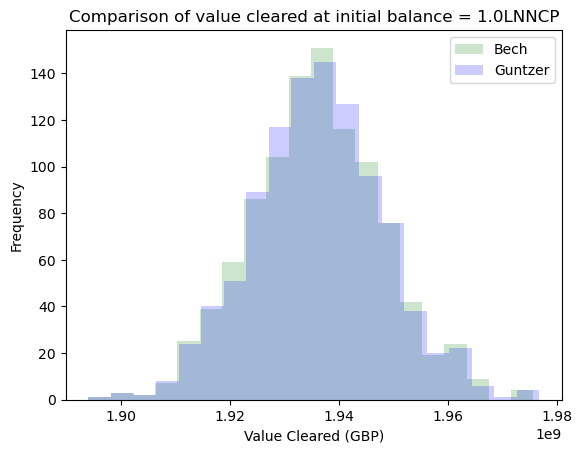

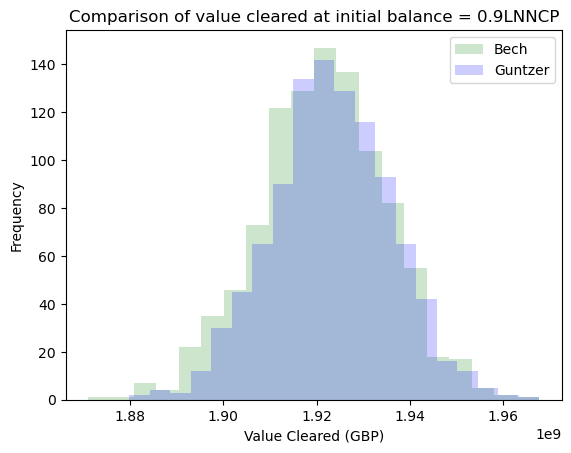

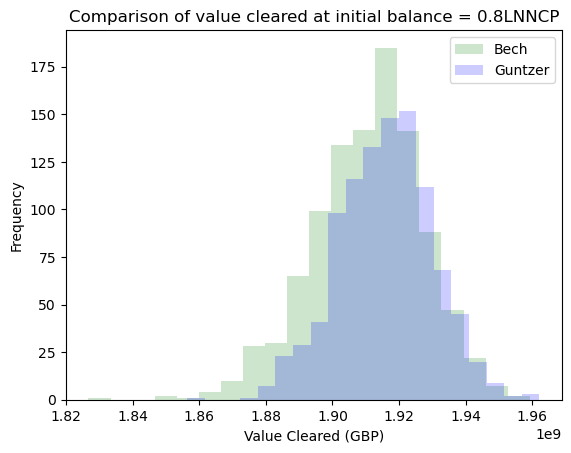

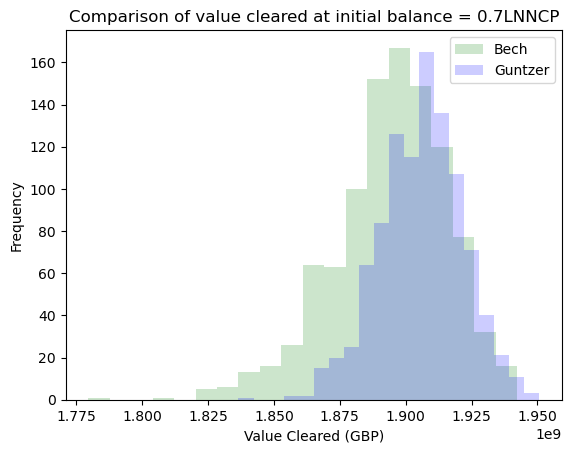

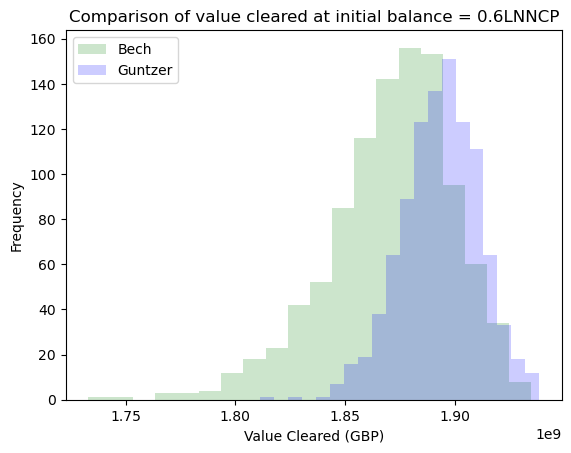

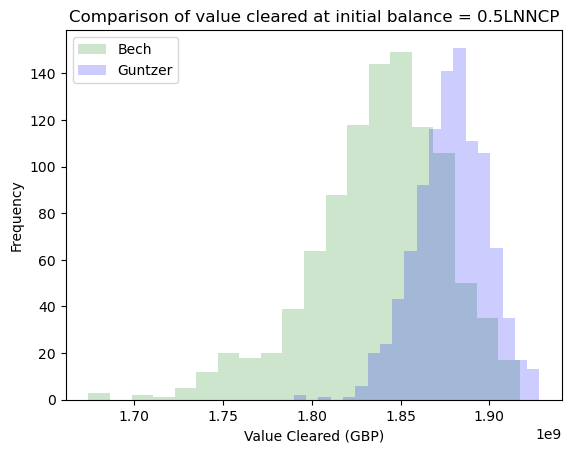

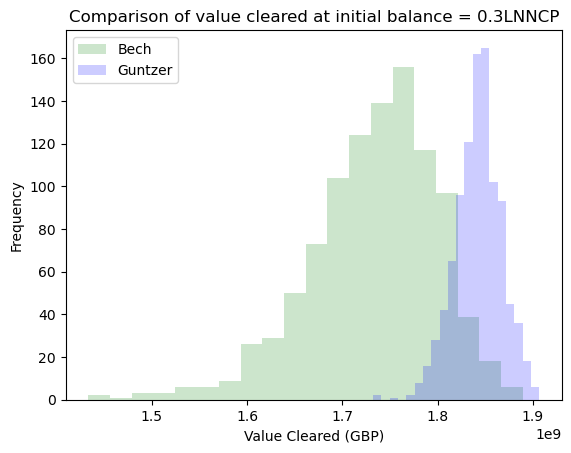

In [11]:
# Plot histograms for value cleared for both algorithms under different initial balances
lamb_list = np.array([0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
j = -1

for i in range(0,28,4):
    plt.hist(compare_df.iloc[:, i], bins=20, alpha=0.2, color='g', label='Bech')
    plt.hist(compare_df.iloc[:, i+28], bins=20, alpha=0.2, color='b', label='Guntzer')

    plt.xlabel('Value Cleared (GBP)')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of value cleared at initial balance = {lamb_list[j]}LNNCP')
    plt.legend()
    plt.savefig(f'Histogram_value_{lamb_list[j]}.png')
    plt.show()
    
    j -= 1

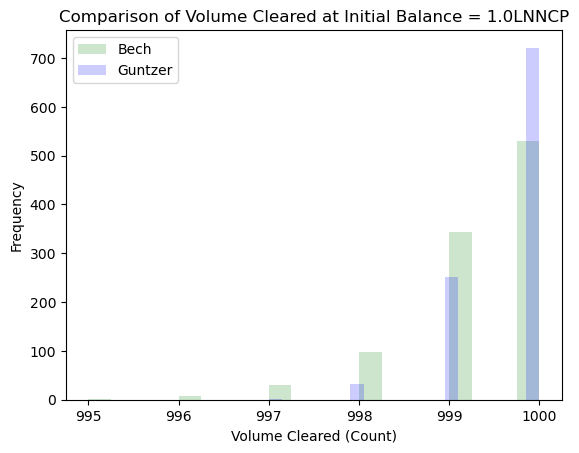

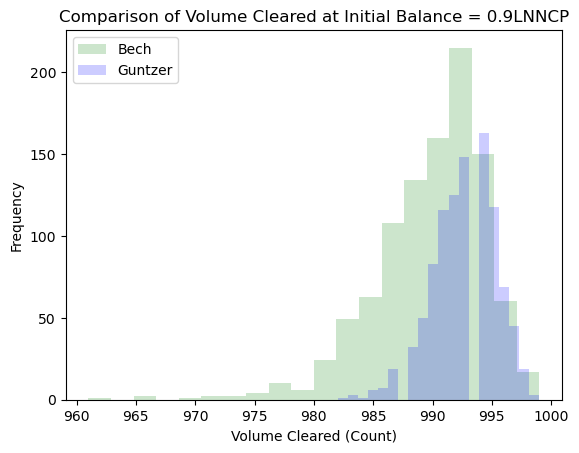

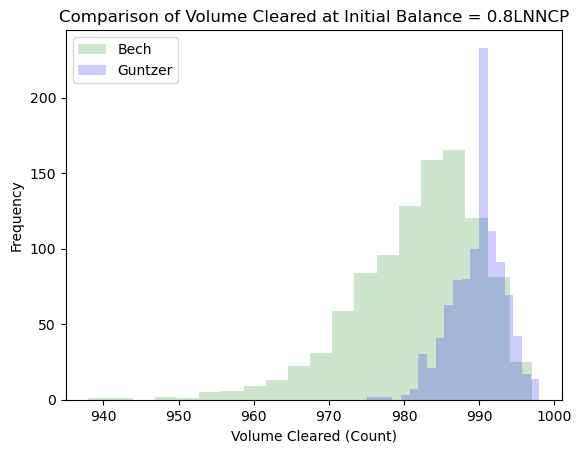

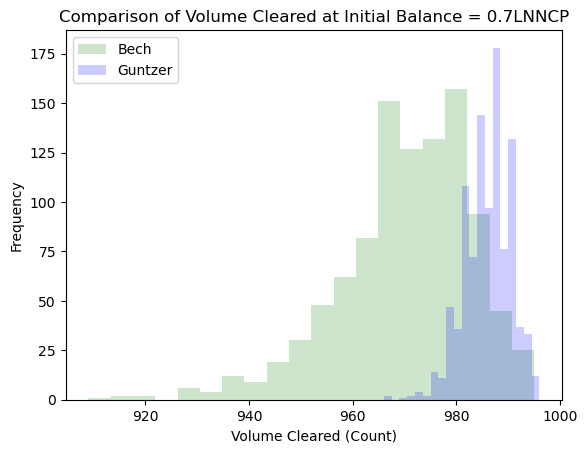

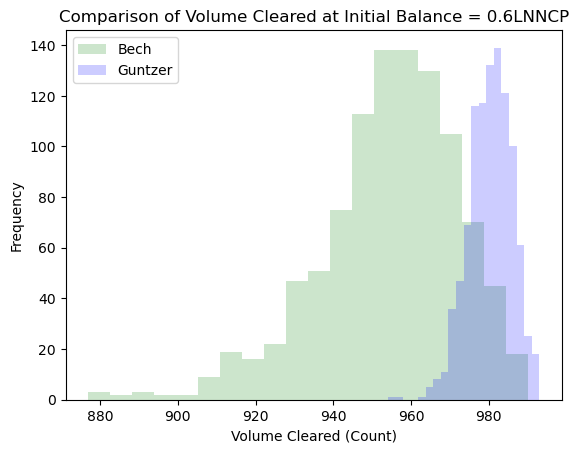

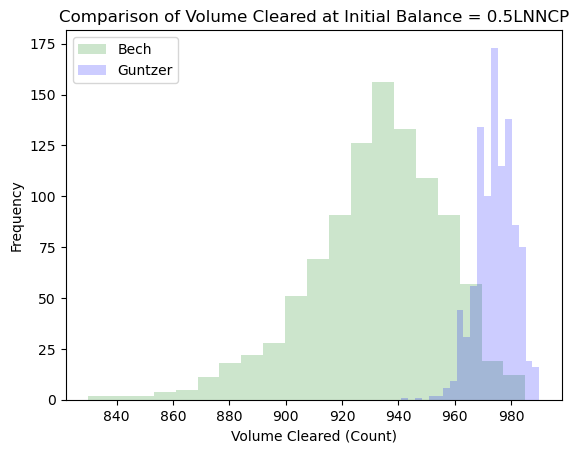

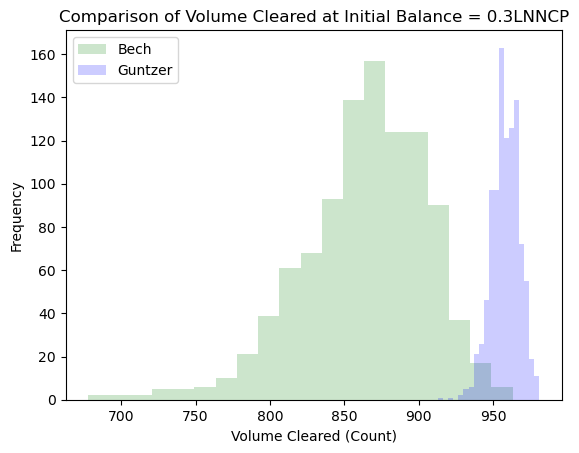

In [12]:
# Plot histograms for volume cleared for both algorithms under different initial balances
j = -1

for i in range(1,28,4):
    plt.hist(compare_df.iloc[:, i], bins=20, alpha=0.2, color='g', label='Bech')
    plt.hist(compare_df.iloc[:, i+28], bins=20, alpha=0.2, color='b', label='Guntzer')

    plt.xlabel('Volume Cleared (Count)')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of Volume Cleared at Initial Balance = {lamb_list[j]}LNNCP')
    plt.legend()
    plt.savefig(f'Histogram_volume_{lamb_list[j]}.png')
    plt.show()
    
    j -= 1

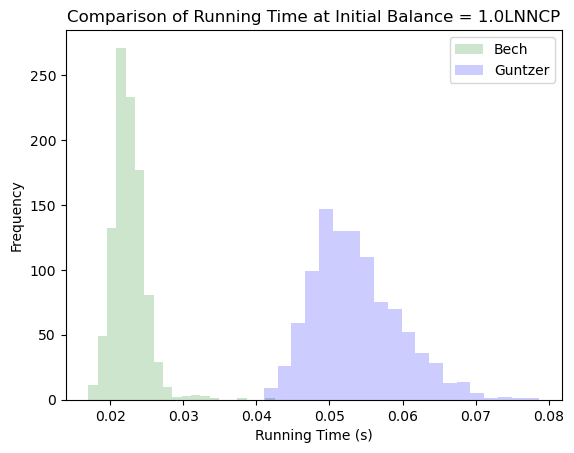

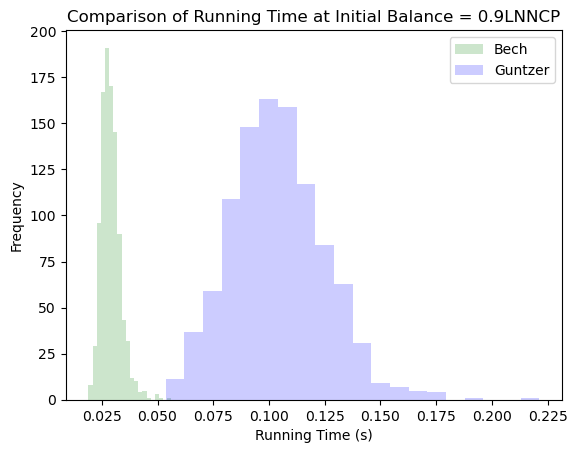

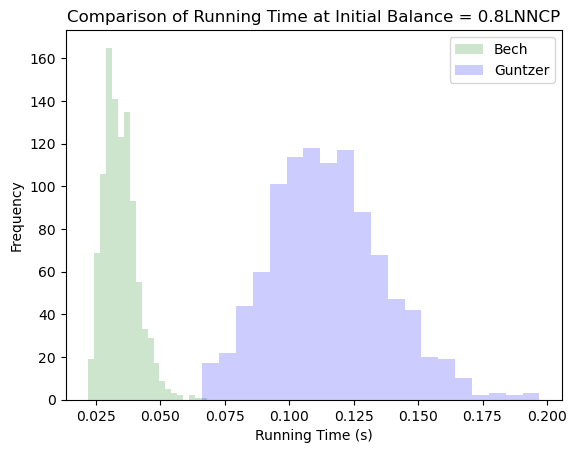

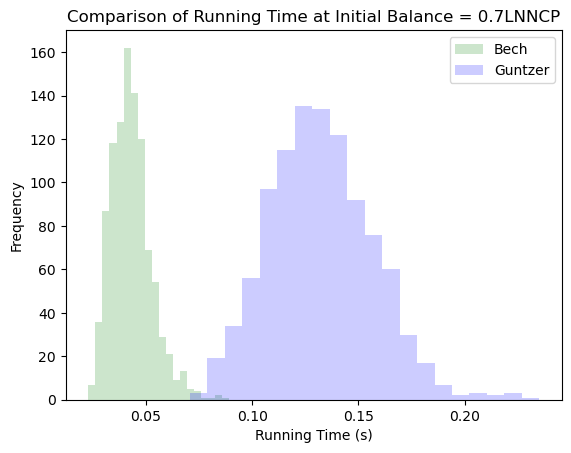

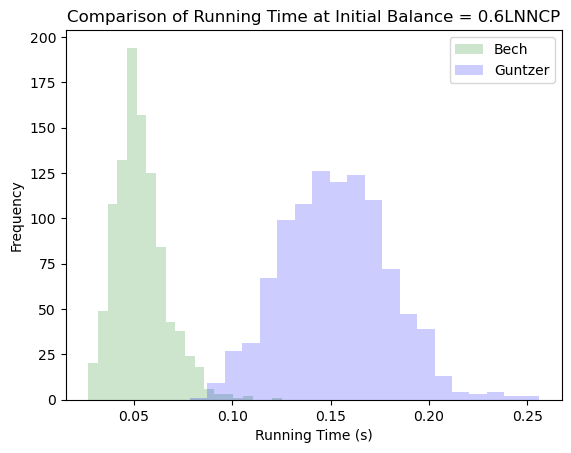

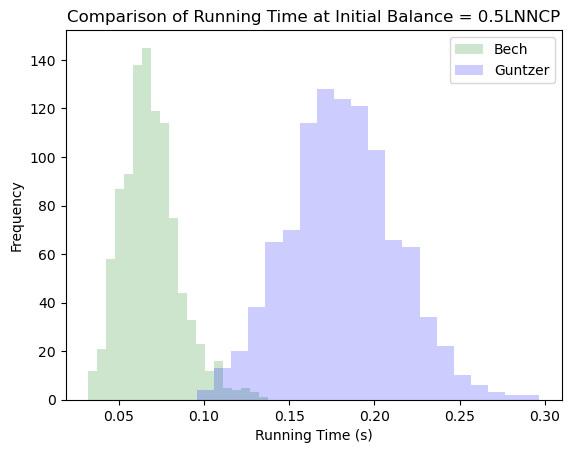

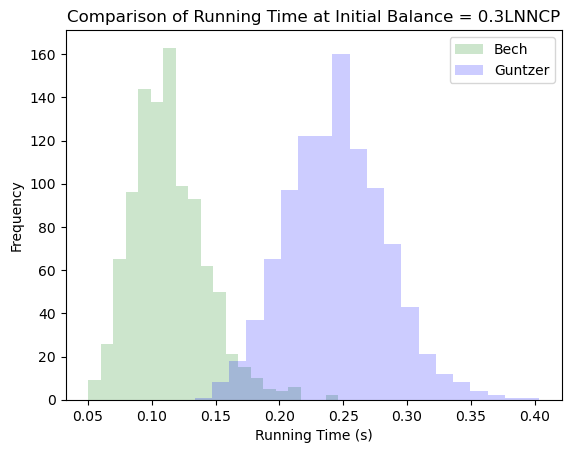

In [13]:
# Plot histograms for running time for both algorithms under different initial balances
j = -1

for i in range(2,28,4):
    plt.hist(compare_df.iloc[:, i], bins=20, alpha=0.2, color='g', label='Bech')
    plt.hist(compare_df.iloc[:, i+28], bins=20, alpha=0.2, color='b', label='Guntzer')

    plt.xlabel('Running Time (s)')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of Running Time at Initial Balance = {lamb_list[j]}LNNCP')
    plt.legend()
    plt.savefig(f'Histogram_time_{lamb_list[j]}.png')
    plt.show()
    
    j -= 1

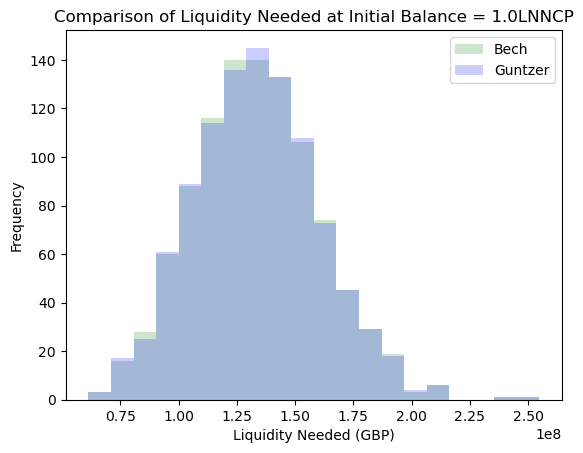

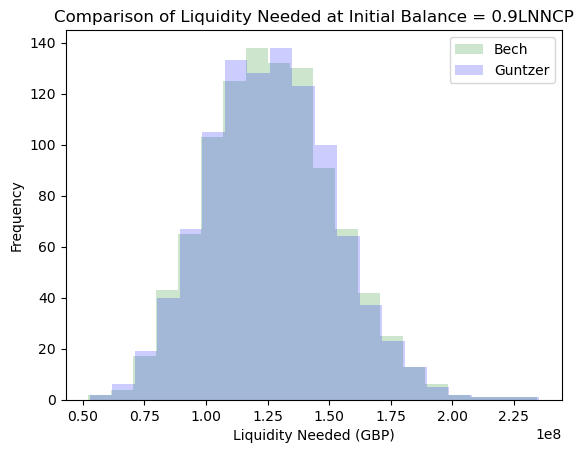

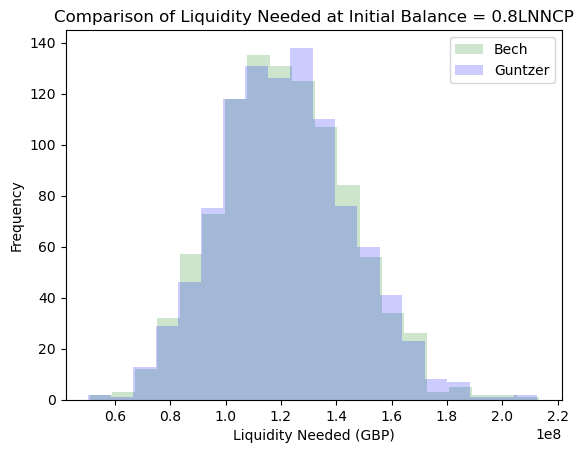

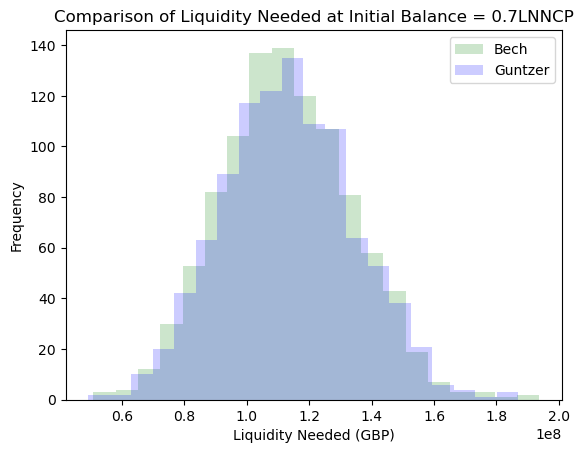

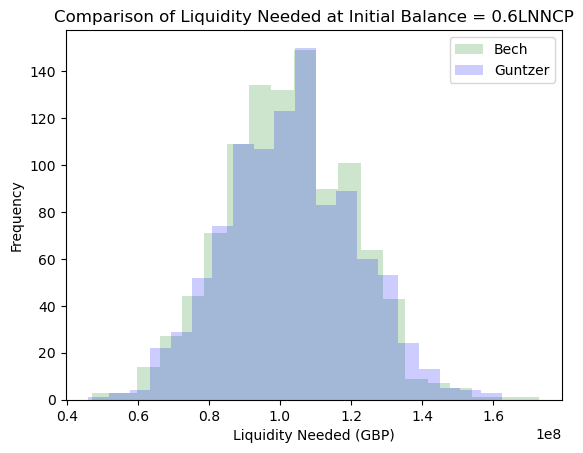

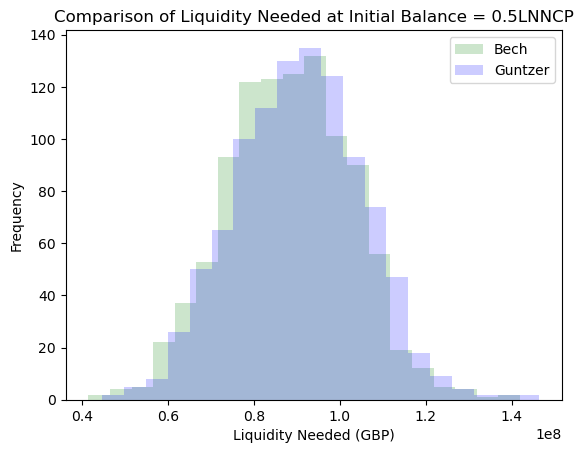

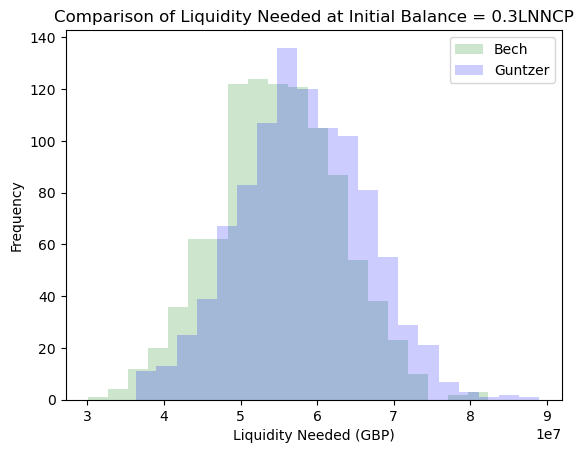

In [14]:
# Plot histograms for liquidity needed for both algorithms under different initial balances
j = -1

for i in range(3,28,4):
    plt.hist(-compare_df.iloc[:, i], bins=20, alpha=0.2, color='g', label='Bech')
    plt.hist(-compare_df.iloc[:, i+28], bins=20, alpha=0.2, color='b', label='Guntzer')

    plt.xlabel('Liquidity Needed (GBP)')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of Liquidity Needed at Initial Balance = {lamb_list[j]}LNNCP')
    plt.legend()
    plt.savefig(f'Histogram_liquidity_{lamb_list[j]}.png')
    plt.show()
    
    j -= 1

## Tests

In [15]:
def Test(column_1, column_2, normal_alpha=0.05, variance_alpha=0.05, t_alpha=0.05, ci_alpha=0.05, bs_alpha=0.05, df=compare_df):
    """
    A test function which compare if there is a significant difference between two columns of a dataframe df.
    Returns: confidence intervals of the two columns.
    """
    df1 = df[column_1]
    df2 = df[column_2]
    # Shapiro-Wilk test for normality
    stat1, p_value1 = shapiro(df1)
    stat2, p_value2 = shapiro(df2)
    
    if p_value1 > normal_alpha and p_value2 > normal_alpha:
        # Levene's test for equal variances (if both behave normal)
        stat, p_value_var = levene(df1, df2)
        if p_value_var > variance_alpha:
            # Perform independent samples t-test (if variances are the same)
            t_statistic, p_value = ttest_ind(df1, df2)
            if p_value < t_alpha:
                print(f"There is a significant difference between the means of {column_1} and {column_2} by T-test.")
            else:
                print(f"There is no significant difference between the means of {column_1} and {column_2} by T-test.")
        else:
            # Perform Welch's t-test (if variances are different)
            t_statistic, p_value = ttest_ind(df1, df2, equal_var=False)
            if p_value < t_alpha:
                print(f"There is a significant difference between the means of {column_1} and {column_2} by Welch's T-test.")
            else:
                print(f"There is no significant difference between the means of {column_1} and {column_2} by Welch's T-test.")
                
        # Calculate confidence interval
        ci1 = st.norm.interval(1 - ci_alpha, loc=np.mean(df1), scale=st.sem(df1)) 
        ci2 = st.norm.interval(1 - ci_alpha, loc=np.mean(df2), scale=st.sem(df2))
        print(f"The confidence interval of mean of {column_1} is {ci1}.")
        print(f"The confidence interval of mean of {column_2} is {ci2}.")
        return ci1, ci2
    
    else:
        print("The data does not appear to be normally distributed.")
        # Bootstrapping (if no normality)
        num_iterations = 1000
        bootstrap_mean1 = [np.mean(resample(df1)) for _ in range(num_iterations)]
        bootstrap_mean2 = [np.mean(resample(df2)) for _ in range(num_iterations)]
        
        # Calculate confidence interval
        a = bs_alpha * 100 / 2
        ci1 = np.percentile(bootstrap_mean1, [a, 100-a])
        ci2 = np.percentile(bootstrap_mean2, [a, 100-a])
        print(f"The confidence interval of mean of {column_1} is {ci1} by Bootstrapping.")
        print(f"The confidence interval of mean of {column_2} is {ci2} by Bootstrapping.")
        return ci1, ci2

In [16]:
# Test the difference and calculate the confidence interval of value cleared for both algorithms
ci1_value_10_1000, ci2_value_10_1000 = Test('value_cleared_B_10_1000', 'value_cleared_G_10_1000')
ci1_value_09_1000, ci2_value_09_1000 = Test('value_cleared_B_09_1000', 'value_cleared_G_09_1000')
ci1_value_08_1000, ci2_value_08_1000 = Test('value_cleared_B_08_1000', 'value_cleared_G_08_1000')
ci1_value_07_1000, ci2_value_07_1000 = Test('value_cleared_B_07_1000', 'value_cleared_G_07_1000')
ci1_value_06_1000, ci2_value_06_1000 = Test('value_cleared_B_06_1000', 'value_cleared_G_06_1000')
ci1_value_05_1000, ci2_value_05_1000 = Test('value_cleared_B_05_1000', 'value_cleared_G_05_1000')
ci1_value_03_1000, ci2_value_03_1000 = Test('value_cleared_B_03_1000', 'value_cleared_G_03_1000')

There is no significant difference between the means of value_cleared_B_10_1000 and value_cleared_G_10_1000 by T-test.
The confidence interval of mean of value_cleared_B_10_1000 is (1935195277.7423315, 1936687179.5791168).
The confidence interval of mean of value_cleared_G_10_1000 is (1935682293.9716978, 1937173302.9438381).
There is a significant difference between the means of value_cleared_B_09_1000 and value_cleared_G_09_1000 by T-test.
The confidence interval of mean of value_cleared_B_09_1000 is (1920469769.2929296, 1922159748.1469908).
The confidence interval of mean of value_cleared_G_09_1000 is (1922420598.3905253, 1924012654.3441372).
The data does not appear to be normally distributed.
The confidence interval of mean of value_cleared_B_08_1000 is [1.90969968e+09 1.91170414e+09] by Bootstrapping.
The confidence interval of mean of value_cleared_G_08_1000 is [1.91513905e+09 1.91683432e+09] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence in

In [17]:
# Test the difference and calculate the confidence interval of volume cleared for both algorithms
ci1_volume_10_1000, ci2_volume_10_1000 = Test('volume_cleared_B_10_1000', 'volume_cleared_G_10_1000')
ci1_volume_09_1000, ci2_volume_09_1000 = Test('volume_cleared_B_09_1000', 'volume_cleared_G_09_1000')
ci1_volume_08_1000, ci2_volume_08_1000 = Test('volume_cleared_B_08_1000', 'volume_cleared_G_08_1000')
ci1_volume_07_1000, ci2_volume_07_1000 = Test('volume_cleared_B_07_1000', 'volume_cleared_G_07_1000')
ci1_volume_06_1000, ci2_volume_06_1000 = Test('volume_cleared_B_06_1000', 'volume_cleared_G_06_1000')
ci1_volume_05_1000, ci2_volume_05_1000 = Test('volume_cleared_B_05_1000', 'volume_cleared_G_05_1000')
ci1_volume_03_1000, ci2_volume_03_1000 = Test('volume_cleared_B_03_1000', 'volume_cleared_G_03_1000')

The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_10_1000 is [999.28370536 999.39285714] by Bootstrapping.
The confidence interval of mean of volume_cleared_G_10_1000 is [999.64186508 999.71230159] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_09_1000 is [989.6110119  990.17958829] by Bootstrapping.
The confidence interval of mean of volume_cleared_G_09_1000 is [992.51381448 992.84228671] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_08_1000 is [981.49794147 982.54573413] by Bootstrapping.
The confidence interval of mean of volume_cleared_G_08_1000 is [989.60116567 990.04072421] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_07_1000 is [969.50198413 971.17666171] by Bootstrapping.
The confidence interval o

In [18]:
# Test the difference and calculate the confidence interval of running time for both algorithms
ci1_time_10_1000, ci2_time_10_1000 = Test('running_time_B_10_1000', 'running_time_G_10_1000')
ci1_time_09_1000, ci2_time_09_1000 = Test('running_time_B_09_1000', 'running_time_G_09_1000')
ci1_time_08_1000, ci2_time_08_1000 = Test('running_time_B_08_1000', 'running_time_G_08_1000')
ci1_time_07_1000, ci2_time_07_1000 = Test('running_time_B_07_1000', 'running_time_G_07_1000')
ci1_time_06_1000, ci2_time_06_1000 = Test('running_time_B_06_1000', 'running_time_G_06_1000')
ci1_time_05_1000, ci2_time_05_1000 = Test('running_time_B_05_1000', 'running_time_G_05_1000')
ci1_time_03_1000, ci2_time_03_1000 = Test('running_time_B_03_1000', 'running_time_G_03_1000')

The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_10_1000 is [0.02242763 0.02270399] by Bootstrapping.
The confidence interval of mean of running_time_G_10_1000 is [0.05326453 0.05399306] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_09_1000 is [0.02874646 0.02927379] by Bootstrapping.
The confidence interval of mean of running_time_G_09_1000 is [0.102722   0.10540815] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_08_1000 is [0.03410207 0.03493784] by Bootstrapping.
The confidence interval of mean of running_time_G_08_1000 is [0.11387381 0.11655891] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_07_1000 is [0.04240306 0.04362679] by Bootstrapping.
The confidence interval of mean of running_time_G_07_1000 is [0.130

In [19]:
# Test the difference and calculate the confidence interval of liquidity needed for both algorithms
ci1_liquidity_10_1000, ci2_liquidity_10_1000 = Test('liquidity_needed_B_10_1000', 'liquidity_needed_G_10_1000')
ci1_liquidity_09_1000, ci2_liquidity_09_1000 = Test('liquidity_needed_B_09_1000', 'liquidity_needed_G_09_1000')
ci1_liquidity_08_1000, ci2_liquidity_08_1000 = Test('liquidity_needed_B_08_1000', 'liquidity_needed_G_08_1000')
ci1_liquidity_07_1000, ci2_liquidity_07_1000 = Test('liquidity_needed_B_07_1000', 'liquidity_needed_G_07_1000')
ci1_liquidity_06_1000, ci2_liquidity_06_1000 = Test('liquidity_needed_B_06_1000', 'liquidity_needed_G_06_1000')
ci1_liquidity_05_1000, ci2_liquidity_05_1000 = Test('liquidity_needed_B_05_1000', 'liquidity_needed_G_05_1000')
ci1_liquidity_03_1000, ci2_liquidity_03_1000 = Test('liquidity_needed_B_03_1000', 'liquidity_needed_G_03_1000')

The data does not appear to be normally distributed.
The confidence interval of mean of liquidity_needed_B_10_1000 is [-1.35066898e+08 -1.31899806e+08] by Bootstrapping.
The confidence interval of mean of liquidity_needed_G_10_1000 is [-1.35304433e+08 -1.32035843e+08] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of liquidity_needed_B_09_1000 is [-1.28085219e+08 -1.25047520e+08] by Bootstrapping.
The confidence interval of mean of liquidity_needed_G_09_1000 is [-1.28409502e+08 -1.25256542e+08] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of liquidity_needed_B_08_1000 is [-1.22735807e+08 -1.19771095e+08] by Bootstrapping.
The confidence interval of mean of liquidity_needed_G_08_1000 is [-1.23207473e+08 -1.20174204e+08] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of liquidity_needed_B_07_1000 is [-1.14327292e+08 -1.1

In [20]:
# Create lists of the confidence intervals grouping by measurements and algorithms
ci_value_B_1000 = [ci1_value_10_1000, ci1_value_09_1000, ci1_value_08_1000, ci1_value_07_1000, ci1_value_06_1000, \
                   ci1_value_05_1000,ci1_value_03_1000]
ci_value_G_1000 = [ci2_value_10_1000, ci2_value_09_1000, ci2_value_08_1000, ci2_value_07_1000, ci2_value_06_1000, \
                   ci2_value_05_1000,ci2_value_03_1000]

ci_volume_B_1000 = [ci1_volume_10_1000, ci1_volume_09_1000, ci1_volume_08_1000, ci1_volume_07_1000, ci1_volume_06_1000, \
                    ci1_volume_05_1000,ci1_volume_03_1000]
ci_volume_G_1000 = [ci2_volume_10_1000, ci2_volume_09_1000, ci2_volume_08_1000, ci2_volume_07_1000, ci2_volume_06_1000, \
                    ci2_volume_05_1000,ci2_volume_03_1000]

ci_time_B_1000 = [ci1_time_10_1000, ci1_time_09_1000, ci1_time_08_1000, ci1_time_07_1000, ci1_time_06_1000, \
                  ci1_time_05_1000,ci1_time_03_1000]
ci_time_G_1000 = [ci2_time_10_1000, ci2_time_09_1000, ci2_time_08_1000, ci2_time_07_1000, ci2_time_06_1000, \
                  ci2_time_05_1000,ci2_time_03_1000]

ci_liquidity_B_1000 = [ci1_liquidity_10_1000, ci1_liquidity_09_1000, ci1_liquidity_08_1000, ci1_liquidity_07_1000, ci1_liquidity_06_1000, \
                       ci1_liquidity_05_1000,ci1_liquidity_03_1000]
ci_liquidity_G_1000 = [ci2_liquidity_10_1000, ci2_liquidity_09_1000, ci2_liquidity_08_1000, ci2_liquidity_07_1000, ci2_liquidity_06_1000, \
                       ci2_liquidity_05_1000,ci2_liquidity_03_1000]

# Reverse the order of lists
ci_value_B_1000 = ci_value_B_1000[::-1]
ci_value_G_1000 = ci_value_G_1000[::-1]

ci_volume_B_1000 = ci_volume_B_1000[::-1]
ci_volume_G_1000 = ci_volume_G_1000[::-1]

ci_time_B_1000 = ci_time_B_1000[::-1]
ci_time_G_1000 = ci_time_G_1000[::-1]

ci_liquidity_B_1000 = ci_liquidity_B_1000[::-1]
ci_liquidity_G_1000 = ci_liquidity_G_1000[::-1]

# Different lengths of queue

In [21]:
# Run both algorithms for queue length 5000
df = pd.read_csv("payments.csv")

value_cleared_G_10_5000, volume_cleared_G_10_5000, value_queue_G_10_5000, volume_queue_G_10_5000, running_time_G_10_5000, liquidity_needed_G_10_5000 = test_Guntzer(df, 5000)
value_cleared_G_09_5000, volume_cleared_G_09_5000, value_queue_G_09_5000, volume_queue_G_09_5000, running_time_G_09_5000, liquidity_needed_G_09_5000 = test_Guntzer(df, 5000, lamb = 0.9)
value_cleared_G_08_5000, volume_cleared_G_08_5000, value_queue_G_08_5000, volume_queue_G_08_5000, running_time_G_08_5000, liquidity_needed_G_08_5000 = test_Guntzer(df, 5000, lamb = 0.8)
value_cleared_G_07_5000, volume_cleared_G_07_5000, value_queue_G_07_5000, volume_queue_G_07_5000, running_time_G_07_5000, liquidity_needed_G_07_5000 = test_Guntzer(df, 5000, lamb = 0.7)
value_cleared_G_06_5000, volume_cleared_G_06_5000, value_queue_G_06_5000, volume_queue_G_06_5000, running_time_G_06_5000, liquidity_needed_G_06_5000 = test_Guntzer(df, 5000, lamb = 0.6)
value_cleared_G_05_5000, volume_cleared_G_05_5000, value_queue_G_05_5000, volume_queue_G_05_5000, running_time_G_05_5000, liquidity_needed_G_05_5000 = test_Guntzer(df, 5000, lamb = 0.5)
value_cleared_G_03_5000, volume_cleared_G_03_5000, value_queue_G_03_5000, volume_queue_G_03_5000, running_time_G_03_5000, liquidity_needed_G_03_5000 = test_Guntzer(df, 5000, lamb = 0.3)

value_cleared_B_10_5000, volume_cleared_B_10_5000, value_queue_B_10_5000, volume_queue_B_10_5000, running_time_B_10_5000, liquidity_needed_B_10_5000 = test_Bech(df, 5000)
value_cleared_B_09_5000, volume_cleared_B_09_5000, value_queue_B_09_5000, volume_queue_B_09_5000, running_time_B_09_5000, liquidity_needed_B_09_5000 = test_Bech(df, 5000, lamb = 0.9)
value_cleared_B_08_5000, volume_cleared_B_08_5000, value_queue_B_08_5000, volume_queue_B_08_5000, running_time_B_08_5000, liquidity_needed_B_08_5000 = test_Bech(df, 5000, lamb = 0.8)
value_cleared_B_07_5000, volume_cleared_B_07_5000, value_queue_B_07_5000, volume_queue_B_07_5000, running_time_B_07_5000, liquidity_needed_B_07_5000 = test_Bech(df, 5000, lamb = 0.7)
value_cleared_B_06_5000, volume_cleared_B_06_5000, value_queue_B_06_5000, volume_queue_B_06_5000, running_time_B_06_5000, liquidity_needed_B_06_5000 = test_Bech(df, 5000, lamb = 0.6)
value_cleared_B_05_5000, volume_cleared_B_05_5000, value_queue_B_05_5000, volume_queue_B_05_5000, running_time_B_05_5000, liquidity_needed_B_05_5000 = test_Bech(df, 5000, lamb = 0.5)
value_cleared_B_03_5000, volume_cleared_B_03_5000, value_queue_B_03_5000, volume_queue_B_03_5000, running_time_B_03_5000, liquidity_needed_B_03_5000 = test_Bech(df, 5000, lamb = 0.3)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [01:54<00:00,  1.76it/s]


In [22]:
# Run both algorithms for queue length 3000
df = pd.read_csv("payments.csv")

value_cleared_G_10_3000, volume_cleared_G_10_3000, value_queue_G_10_3000, volume_queue_G_10_3000, running_time_G_10_3000, liquidity_needed_G_10_3000 = test_Guntzer(df, 3000)
value_cleared_G_09_3000, volume_cleared_G_09_3000, value_queue_G_09_3000, volume_queue_G_09_3000, running_time_G_09_3000, liquidity_needed_G_09_3000 = test_Guntzer(df, 3000, lamb = 0.9)
value_cleared_G_08_3000, volume_cleared_G_08_3000, value_queue_G_08_3000, volume_queue_G_08_3000, running_time_G_08_3000, liquidity_needed_G_08_3000 = test_Guntzer(df, 3000, lamb = 0.8)
value_cleared_G_07_3000, volume_cleared_G_07_3000, value_queue_G_07_3000, volume_queue_G_07_3000, running_time_G_07_3000, liquidity_needed_G_07_3000 = test_Guntzer(df, 3000, lamb = 0.7)
value_cleared_G_06_3000, volume_cleared_G_06_3000, value_queue_G_06_3000, volume_queue_G_06_3000, running_time_G_06_3000, liquidity_needed_G_06_3000 = test_Guntzer(df, 3000, lamb = 0.6)
value_cleared_G_05_3000, volume_cleared_G_05_3000, value_queue_G_05_3000, volume_queue_G_05_3000, running_time_G_05_3000, liquidity_needed_G_05_3000 = test_Guntzer(df, 3000, lamb = 0.5)
value_cleared_G_03_3000, volume_cleared_G_03_3000, value_queue_G_03_3000, volume_queue_G_03_3000, running_time_G_03_3000, liquidity_needed_G_03_3000 = test_Guntzer(df, 3000, lamb = 0.3)

value_cleared_B_10_3000, volume_cleared_B_10_3000, value_queue_B_10_3000, volume_queue_B_10_3000, running_time_B_10_3000, liquidity_needed_B_10_3000 = test_Bech(df, 3000)
value_cleared_B_09_3000, volume_cleared_B_09_3000, value_queue_B_09_3000, volume_queue_B_09_3000, running_time_B_09_3000, liquidity_needed_B_09_3000 = test_Bech(df, 3000, lamb = 0.9)
value_cleared_B_08_3000, volume_cleared_B_08_3000, value_queue_B_08_3000, volume_queue_B_08_3000, running_time_B_08_3000, liquidity_needed_B_08_3000 = test_Bech(df, 3000, lamb = 0.8)
value_cleared_B_07_3000, volume_cleared_B_07_3000, value_queue_B_07_3000, volume_queue_B_07_3000, running_time_B_07_3000, liquidity_needed_B_07_3000 = test_Bech(df, 3000, lamb = 0.7)
value_cleared_B_06_3000, volume_cleared_B_06_3000, value_queue_B_06_3000, volume_queue_B_06_3000, running_time_B_06_3000, liquidity_needed_B_06_3000 = test_Bech(df, 3000, lamb = 0.6)
value_cleared_B_05_3000, volume_cleared_B_05_3000, value_queue_B_05_3000, volume_queue_B_05_3000, running_time_B_05_3000, liquidity_needed_B_05_3000 = test_Bech(df, 3000, lamb = 0.5)
value_cleared_B_03_3000, volume_cleared_B_03_3000, value_queue_B_03_3000, volume_queue_B_03_3000, running_time_B_03_3000, liquidity_needed_B_03_3000 = test_Bech(df, 3000, lamb = 0.3)

100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [02:08<00:00,  2.60it/s]


In [23]:
# Create a dataframe containing four measurements under different initial balances (queue length 5000)
list_of_lists_5000 = ['value_cleared_B_10_5000',  'volume_cleared_B_10_5000', 'running_time_B_10_5000', 'liquidity_needed_B_10_5000', \
                      'value_cleared_B_09_5000',  'volume_cleared_B_09_5000', 'running_time_B_09_5000', 'liquidity_needed_B_09_5000', \
                      'value_cleared_B_08_5000',  'volume_cleared_B_08_5000', 'running_time_B_08_5000', 'liquidity_needed_B_08_5000', \
                      'value_cleared_B_07_5000',  'volume_cleared_B_07_5000', 'running_time_B_07_5000', 'liquidity_needed_B_07_5000', \
                      'value_cleared_B_06_5000',  'volume_cleared_B_06_5000', 'running_time_B_06_5000', 'liquidity_needed_B_06_5000', \
                      'value_cleared_B_05_5000',  'volume_cleared_B_05_5000', 'running_time_B_05_5000', 'liquidity_needed_B_05_5000', \
                      'value_cleared_B_03_5000',  'volume_cleared_B_03_5000', 'running_time_B_03_5000', 'liquidity_needed_B_03_5000', \
                      'value_cleared_G_10_5000',  'volume_cleared_G_10_5000', 'running_time_G_10_5000', 'liquidity_needed_G_10_5000', \
                      'value_cleared_G_09_5000',  'volume_cleared_G_09_5000', 'running_time_G_09_5000', 'liquidity_needed_G_09_5000', \
                      'value_cleared_G_08_5000',  'volume_cleared_G_08_5000', 'running_time_G_08_5000', 'liquidity_needed_G_08_5000', \
                      'value_cleared_G_07_5000',  'volume_cleared_G_07_5000', 'running_time_G_07_5000', 'liquidity_needed_G_07_5000', \
                      'value_cleared_G_06_5000',  'volume_cleared_G_06_5000', 'running_time_G_06_5000', 'liquidity_needed_G_06_5000', \
                      'value_cleared_G_05_5000',  'volume_cleared_G_05_5000', 'running_time_G_05_5000', 'liquidity_needed_G_05_5000', \
                      'value_cleared_G_03_5000',  'volume_cleared_G_03_5000', 'running_time_G_03_5000', 'liquidity_needed_G_03_5000', \
                      'value_queue_G_10_5000',  'volume_queue_G_10_5000']
compare_data_5000 = {name: globals()[name] for name in list_of_lists_5000}
compare_df_5000 = pd.DataFrame(compare_data_5000)
compare_df_5000.rename(columns={'value_queue_G_10_5000': 'value_queue', 'volume_queue_G_10_5000': 'volume_queue'}, inplace=True)
compare_df_5000.head()

,value_cleared_B_10_5000,volume_cleared_B_10_5000,running_time_B_10_5000,liquidity_needed_B_10_5000,value_cleared_B_09_5000,volume_cleared_B_09_5000,running_time_B_09_5000,liquidity_needed_B_09_5000,value_cleared_B_08_5000,volume_cleared_B_08_5000,...,value_cleared_G_05_5000,volume_cleared_G_05_5000,running_time_G_05_5000,liquidity_needed_G_05_5000,value_cleared_G_03_5000,volume_cleared_G_03_5000,running_time_G_03_5000,liquidity_needed_G_03_5000,value_queue,volume_queue
0,9.667014e+09,5000,0.040389,-2.432663e+08,9.654924e+09,4992,0.048550,-2.391108e+08,9.635852e+09,4976,...,9.568271e+09,4960,0.685548,-1.790312e+08,9.502048e+09,4933,0.989193,-1.408361e+08,9.667014e+09,5000
1,9.640530e+09,4998,0.043699,-3.155363e+08,9.630534e+09,4990,0.053192,-3.110106e+08,9.609380e+09,4973,...,9.522420e+09,4953,0.771724,-2.271999e+08,9.427837e+09,4912,1.226855,-1.645831e+08,9.643451e+09,5000
2,9.690885e+09,5000,0.039993,-2.721167e+08,9.681408e+09,4995,0.045010,-2.677580e+08,9.681408e+09,4995,...,9.615558e+09,4970,0.625998,-2.129637e+08,9.534028e+09,4937,0.982165,-1.402570e+08,9.690885e+09,5000
3,9.704869e+09,5000,0.039081,-3.460458e+08,9.689830e+09,4989,0.052543,-3.355454e+08,9.662167e+09,4967,...,9.565830e+09,4947,0.822846,-2.344389e+08,9.472951e+09,4909,1.193137,-1.498339e+08,9.704869e+09,5000
4,9.717494e+09,4998,0.041753,-2.072314e+08,9.706885e+09,4991,0.049079,-2.061131e+08,9.700687e+09,4986,...,9.645409e+09,4968,0.620591,-1.685568e+08,9.594018e+09,4944,0.931810,-1.242870e+08,9.720184e+09,5000


In [24]:
# Create a dataframe containing four measurements under different initial balances (queue length 3000)
list_of_lists_3000 = ['value_cleared_B_10_3000',  'volume_cleared_B_10_3000', 'running_time_B_10_3000', 'liquidity_needed_B_10_3000', \
                      'value_cleared_B_09_3000',  'volume_cleared_B_09_3000', 'running_time_B_09_3000', 'liquidity_needed_B_09_3000', \
                      'value_cleared_B_08_3000',  'volume_cleared_B_08_3000', 'running_time_B_08_3000', 'liquidity_needed_B_08_3000', \
                      'value_cleared_B_07_3000',  'volume_cleared_B_07_3000', 'running_time_B_07_3000', 'liquidity_needed_B_07_3000', \
                      'value_cleared_B_06_3000',  'volume_cleared_B_06_3000', 'running_time_B_06_3000', 'liquidity_needed_B_06_3000', \
                      'value_cleared_B_05_3000',  'volume_cleared_B_05_3000', 'running_time_B_05_3000', 'liquidity_needed_B_05_3000', \
                      'value_cleared_B_03_3000',  'volume_cleared_B_03_3000', 'running_time_B_03_3000', 'liquidity_needed_B_03_3000', \
                      'value_cleared_G_10_3000',  'volume_cleared_G_10_3000', 'running_time_G_10_3000', 'liquidity_needed_G_10_3000', \
                      'value_cleared_G_09_3000',  'volume_cleared_G_09_3000', 'running_time_G_09_3000', 'liquidity_needed_G_09_3000', \
                      'value_cleared_G_08_3000',  'volume_cleared_G_08_3000', 'running_time_G_08_3000', 'liquidity_needed_G_08_3000', \
                      'value_cleared_G_07_3000',  'volume_cleared_G_07_3000', 'running_time_G_07_3000', 'liquidity_needed_G_07_3000', \
                      'value_cleared_G_06_3000',  'volume_cleared_G_06_3000', 'running_time_G_06_3000', 'liquidity_needed_G_06_3000', \
                      'value_cleared_G_05_3000',  'volume_cleared_G_05_3000', 'running_time_G_05_3000', 'liquidity_needed_G_05_3000', \
                      'value_cleared_G_03_3000',  'volume_cleared_G_03_3000', 'running_time_G_03_3000', 'liquidity_needed_G_03_3000', \
                      'value_queue_G_10_3000',  'volume_queue_G_10_3000']
compare_data_3000 = {name: globals()[name] for name in list_of_lists_3000}
compare_df_3000 = pd.DataFrame(compare_data_3000)
compare_df_3000.rename(columns={'value_queue_G_10_3000': 'value_queue', 'volume_queue_G_10_3000': 'volume_queue'}, inplace=True)
compare_df_3000.head()

,value_cleared_B_10_3000,volume_cleared_B_10_3000,running_time_B_10_3000,liquidity_needed_B_10_3000,value_cleared_B_09_3000,volume_cleared_B_09_3000,running_time_B_09_3000,liquidity_needed_B_09_3000,value_cleared_B_08_3000,volume_cleared_B_08_3000,...,value_cleared_G_05_3000,volume_cleared_G_05_3000,running_time_G_05_3000,liquidity_needed_G_05_3000,value_cleared_G_03_3000,volume_cleared_G_03_3000,running_time_G_03_3000,liquidity_needed_G_03_3000,value_queue,volume_queue
0,5.782596e+09,2999,0.031632,-2.088616e+08,5.765797e+09,2988,0.041163,-1.983066e+08,5.744934e+09,2971,...,5.698772e+09,2966,0.430894,-1.556799e+08,5.644330e+09,2942,0.589243,-1.074708e+08,5.783859e+09,3000
1,5.829037e+09,2997,0.035573,-1.586552e+08,5.825458e+09,2995,0.038548,-1.550760e+08,5.819730e+09,2990,...,5.788068e+09,2979,0.353277,-1.374293e+08,5.747187e+09,2963,0.450838,-9.199966e+07,5.833498e+09,3000
2,5.799042e+09,3000,0.031112,-2.857392e+08,5.776030e+09,2983,0.046741,-2.715074e+08,5.754174e+09,2967,...,5.679827e+09,2948,0.579764,-1.685985e+08,5.607798e+09,2918,0.796487,-1.149663e+08,5.799042e+09,3000
3,5.759084e+09,2998,0.035008,-2.056922e+08,5.747206e+09,2992,0.039966,-2.036781e+08,5.732695e+09,2980,...,5.679431e+09,2966,0.426781,-1.456805e+08,5.615546e+09,2939,0.620600,-9.749629e+07,5.762272e+09,3000
4,5.822680e+09,3000,0.031165,-2.061621e+08,5.813996e+09,2995,0.036134,-2.001258e+08,5.804035e+09,2987,...,5.750310e+09,2971,0.365464,-1.385271e+08,5.688452e+09,2946,0.525648,-1.011309e+08,5.822680e+09,3000


In [25]:
# Test the difference and calculate the value cleared of liquidity needed for both algorithms
ci1_value_10_3000, ci2_value_10_3000 = Test('value_cleared_B_10_3000', 'value_cleared_G_10_3000', df = compare_df_3000)
ci1_value_09_3000, ci2_value_09_3000 = Test('value_cleared_B_09_3000', 'value_cleared_G_09_3000', df = compare_df_3000)
ci1_value_08_3000, ci2_value_08_3000 = Test('value_cleared_B_08_3000', 'value_cleared_G_08_3000', df = compare_df_3000)
ci1_value_07_3000, ci2_value_07_3000 = Test('value_cleared_B_07_3000', 'value_cleared_G_07_3000', df = compare_df_3000)
ci1_value_06_3000, ci2_value_06_3000 = Test('value_cleared_B_06_3000', 'value_cleared_G_06_3000', df = compare_df_3000)
ci1_value_05_3000, ci2_value_05_3000 = Test('value_cleared_B_05_3000', 'value_cleared_G_05_3000', df = compare_df_3000)
ci1_value_03_3000, ci2_value_03_3000 = Test('value_cleared_B_03_3000', 'value_cleared_G_03_3000', df = compare_df_3000)

ci1_value_10_5000, ci2_value_10_5000 = Test('value_cleared_B_10_5000', 'value_cleared_G_10_5000', df = compare_df_5000)
ci1_value_09_5000, ci2_value_09_5000 = Test('value_cleared_B_09_5000', 'value_cleared_G_09_5000', df = compare_df_5000)
ci1_value_08_5000, ci2_value_08_5000 = Test('value_cleared_B_08_5000', 'value_cleared_G_08_5000', df = compare_df_5000)
ci1_value_07_5000, ci2_value_07_5000 = Test('value_cleared_B_07_5000', 'value_cleared_G_07_5000', df = compare_df_5000)
ci1_value_06_5000, ci2_value_06_5000 = Test('value_cleared_B_06_5000', 'value_cleared_G_06_5000', df = compare_df_5000)
ci1_value_05_5000, ci2_value_05_5000 = Test('value_cleared_B_05_5000', 'value_cleared_G_05_5000', df = compare_df_5000)
ci1_value_03_5000, ci2_value_03_5000 = Test('value_cleared_B_03_5000', 'value_cleared_G_03_5000', df = compare_df_5000)

There is no significant difference between the means of value_cleared_B_10_3000 and value_cleared_G_10_3000 by T-test.
The confidence interval of mean of value_cleared_B_10_3000 is (5807377700.271714, 5811716120.480725).
The confidence interval of mean of value_cleared_G_10_3000 is (5807943450.590825, 5812295269.038043).
There is no significant difference between the means of value_cleared_B_09_3000 and value_cleared_G_09_3000 by T-test.
The confidence interval of mean of value_cleared_B_09_3000 is (5791103039.2652855, 5795753248.485846).
The confidence interval of mean of value_cleared_G_09_3000 is (5793114658.138215, 5797631689.782975).
There is a significant difference between the means of value_cleared_B_08_3000 and value_cleared_G_08_3000 by Welch's T-test.
The confidence interval of mean of value_cleared_B_08_3000 is (5774721926.889426, 5780184109.631108).
The confidence interval of mean of value_cleared_G_08_3000 is (5781345789.829698, 5786237381.382743).
The data does not appea

In [26]:
# Test the difference and calculate the confidence interval of volume cleared for both algorithms
ci1_volume_10_3000, ci2_volume_10_3000 = Test('volume_cleared_B_10_3000', 'volume_cleared_G_10_3000', df = compare_df_3000)
ci1_volume_09_3000, ci2_volume_09_3000 = Test('volume_cleared_B_09_3000', 'volume_cleared_G_09_3000', df = compare_df_3000)
ci1_volume_08_3000, ci2_volume_08_3000 = Test('volume_cleared_B_08_3000', 'volume_cleared_G_08_3000', df = compare_df_3000)
ci1_volume_07_3000, ci2_volume_07_3000 = Test('volume_cleared_B_07_3000', 'volume_cleared_G_07_3000', df = compare_df_3000)
ci1_volume_06_3000, ci2_volume_06_3000 = Test('volume_cleared_B_06_3000', 'volume_cleared_G_06_3000', df = compare_df_3000)
ci1_volume_05_3000, ci2_volume_05_3000 = Test('volume_cleared_B_05_3000', 'volume_cleared_G_05_3000', df = compare_df_3000)
ci1_volume_03_3000, ci2_volume_03_3000 = Test('volume_cleared_B_03_3000', 'volume_cleared_G_03_3000', df = compare_df_3000)

ci1_volume_10_5000, ci2_volume_10_5000 = Test('volume_cleared_B_10_5000', 'volume_cleared_G_10_5000', df = compare_df_5000)
ci1_volume_09_5000, ci2_volume_09_5000 = Test('volume_cleared_B_09_5000', 'volume_cleared_G_09_5000', df = compare_df_5000)
ci1_volume_08_5000, ci2_volume_08_5000 = Test('volume_cleared_B_08_5000', 'volume_cleared_G_08_5000', df = compare_df_5000)
ci1_volume_07_5000, ci2_volume_07_5000 = Test('volume_cleared_B_07_5000', 'volume_cleared_G_07_5000', df = compare_df_5000)
ci1_volume_06_5000, ci2_volume_06_5000 = Test('volume_cleared_B_06_5000', 'volume_cleared_G_06_5000', df = compare_df_5000)
ci1_volume_05_5000, ci2_volume_05_5000 = Test('volume_cleared_B_05_5000', 'volume_cleared_G_05_5000', df = compare_df_5000)
ci1_volume_03_5000, ci2_volume_03_5000 = Test('volume_cleared_B_03_5000', 'volume_cleared_G_03_5000', df = compare_df_5000)

The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_10_3000 is [2999.14873512 2999.32142857] by Bootstrapping.
The confidence interval of mean of volume_cleared_G_10_3000 is [2999.56845238 2999.69047619] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_09_3000 is [2987.53563988 2988.8781994 ] by Bootstrapping.
The confidence interval of mean of volume_cleared_G_09_3000 is [2991.73809524 2992.36912202] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_08_3000 is [2974.47247024 2977.0625744 ] by Bootstrapping.
The confidence interval of mean of volume_cleared_G_08_3000 is [2987.30059524 2988.22626488] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of volume_cleared_B_07_3000 is [2953.69330357 2958.20550595] by Bootstrapping.
The confide

In [27]:
# Test the difference and calculate the confidence interval of running time for both algorithms
ci1_time_10_3000, ci2_time_10_3000 = Test('running_time_B_10_3000', 'running_time_G_10_3000', df = compare_df_3000)
ci1_time_09_3000, ci2_time_09_3000 = Test('running_time_B_09_3000', 'running_time_G_09_3000', df = compare_df_3000)
ci1_time_08_3000, ci2_time_08_3000 = Test('running_time_B_08_3000', 'running_time_G_08_3000', df = compare_df_3000)
ci1_time_07_3000, ci2_time_07_3000 = Test('running_time_B_07_3000', 'running_time_G_07_3000', df = compare_df_3000)
ci1_time_06_3000, ci2_time_06_3000 = Test('running_time_B_06_3000', 'running_time_G_06_3000', df = compare_df_3000)
ci1_time_05_3000, ci2_time_05_3000 = Test('running_time_B_05_3000', 'running_time_G_05_3000', df = compare_df_3000)
ci1_time_03_3000, ci2_time_03_3000 = Test('running_time_B_03_3000', 'running_time_G_03_3000', df = compare_df_3000)

ci1_time_10_5000, ci2_time_10_5000 = Test('running_time_B_10_5000', 'running_time_G_10_5000', df = compare_df_5000)
ci1_time_09_5000, ci2_time_09_5000 = Test('running_time_B_09_5000', 'running_time_G_09_5000', df = compare_df_5000)
ci1_time_08_5000, ci2_time_08_5000 = Test('running_time_B_08_5000', 'running_time_G_08_5000', df = compare_df_5000)
ci1_time_07_5000, ci2_time_07_5000 = Test('running_time_B_07_5000', 'running_time_G_07_5000', df = compare_df_5000)
ci1_time_06_5000, ci2_time_06_5000 = Test('running_time_B_06_5000', 'running_time_G_06_5000', df = compare_df_5000)
ci1_time_05_5000, ci2_time_05_5000 = Test('running_time_B_05_5000', 'running_time_G_05_5000', df = compare_df_5000)
ci1_time_03_5000, ci2_time_03_5000 = Test('running_time_B_03_5000', 'running_time_G_03_5000', df = compare_df_5000)

The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_10_3000 is [0.03173815 0.03235841] by Bootstrapping.
The confidence interval of mean of running_time_G_10_3000 is [0.08206365 0.08442827] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_09_3000 is [0.04053327 0.04172269] by Bootstrapping.
The confidence interval of mean of running_time_G_09_3000 is [0.20235933 0.21221159] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_08_3000 is [0.05212146 0.05446475] by Bootstrapping.
The confidence interval of mean of running_time_G_08_3000 is [0.24515308 0.25603934] by Bootstrapping.
The data does not appear to be normally distributed.
The confidence interval of mean of running_time_B_07_3000 is [0.0694072  0.07342966] by Bootstrapping.
The confidence interval of mean of running_time_G_07_3000 is [0.296

In [28]:
# Test the difference and calculate the confidence interval of liquidity needed for both algorithms
ci1_liquidity_10_3000, ci2_liquidity_10_3000 = Test('liquidity_needed_B_10_3000', 'liquidity_needed_G_10_3000', df = compare_df_3000)
ci1_liquidity_09_3000, ci2_liquidity_09_3000 = Test('liquidity_needed_B_09_3000', 'liquidity_needed_G_09_3000', df = compare_df_3000)
ci1_liquidity_08_3000, ci2_liquidity_08_3000 = Test('liquidity_needed_B_08_3000', 'liquidity_needed_G_08_3000', df = compare_df_3000)
ci1_liquidity_07_3000, ci2_liquidity_07_3000 = Test('liquidity_needed_B_07_3000', 'liquidity_needed_G_07_3000', df = compare_df_3000)
ci1_liquidity_06_3000, ci2_liquidity_06_3000 = Test('liquidity_needed_B_06_3000', 'liquidity_needed_G_06_3000', df = compare_df_3000)
ci1_liquidity_05_3000, ci2_liquidity_05_3000 = Test('liquidity_needed_B_05_3000', 'liquidity_needed_G_05_3000', df = compare_df_3000)
ci1_liquidity_03_3000, ci2_liquidity_03_3000 = Test('liquidity_needed_B_03_3000', 'liquidity_needed_G_03_3000', df = compare_df_3000)

ci1_liquidity_10_5000, ci2_liquidity_10_5000 = Test('liquidity_needed_B_10_5000', 'liquidity_needed_G_10_5000', df = compare_df_5000)
ci1_liquidity_09_5000, ci2_liquidity_09_5000 = Test('liquidity_needed_B_09_5000', 'liquidity_needed_G_09_5000', df = compare_df_5000)
ci1_liquidity_08_5000, ci2_liquidity_08_5000 = Test('liquidity_needed_B_08_5000', 'liquidity_needed_G_08_5000', df = compare_df_5000)
ci1_liquidity_07_5000, ci2_liquidity_07_5000 = Test('liquidity_needed_B_07_5000', 'liquidity_needed_G_07_5000', df = compare_df_5000)
ci1_liquidity_06_5000, ci2_liquidity_06_5000 = Test('liquidity_needed_B_06_5000', 'liquidity_needed_G_06_5000', df = compare_df_5000)
ci1_liquidity_05_5000, ci2_liquidity_05_5000 = Test('liquidity_needed_B_05_5000', 'liquidity_needed_G_05_5000', df = compare_df_5000)
ci1_liquidity_03_5000, ci2_liquidity_03_5000 = Test('liquidity_needed_B_03_5000', 'liquidity_needed_G_03_5000', df = compare_df_5000)

The data does not appear to be normally distributed.
The confidence interval of mean of liquidity_needed_B_10_3000 is [-2.35492946e+08 -2.25237289e+08] by Bootstrapping.
The confidence interval of mean of liquidity_needed_G_10_3000 is [-2.35374000e+08 -2.25986626e+08] by Bootstrapping.
There is no significant difference between the means of liquidity_needed_B_09_3000 and liquidity_needed_G_09_3000 by T-test.
The confidence interval of mean of liquidity_needed_B_09_3000 is (-227369396.79196218, -217765514.3591092).
The confidence interval of mean of liquidity_needed_G_09_3000 is (-227438435.1143719, -217851532.62330663).
There is no significant difference between the means of liquidity_needed_B_08_3000 and liquidity_needed_G_08_3000 by T-test.
The confidence interval of mean of liquidity_needed_B_08_3000 is (-218697221.5319547, -209723174.91530722).
The confidence interval of mean of liquidity_needed_G_08_3000 is (-219209360.74157667, -210221892.2175305).
There is no significant differe

In [29]:
# Create lists of the confidence intervals grouping by measurements and algorithms (queue length 3000)
ci_value_B_3000 = [ci1_value_10_3000, ci1_value_09_3000, ci1_value_08_3000, ci1_value_07_3000, ci1_value_06_3000, \
                   ci1_value_05_3000,ci1_value_03_3000]
ci_value_G_3000 = [ci2_value_10_3000, ci2_value_09_3000, ci2_value_08_3000, ci2_value_07_3000, ci2_value_06_3000, \
                   ci2_value_05_3000,ci2_value_03_3000]

ci_volume_B_3000 = [ci1_volume_10_3000, ci1_volume_09_3000, ci1_volume_08_3000, ci1_volume_07_3000, ci1_volume_06_3000, \
                    ci1_volume_05_3000,ci1_volume_03_3000]
ci_volume_G_3000 = [ci2_volume_10_3000, ci2_volume_09_3000, ci2_volume_08_3000, ci2_volume_07_3000, ci2_volume_06_3000, \
                    ci2_volume_05_3000,ci2_volume_03_3000]

ci_time_B_3000 = [ci1_time_10_3000, ci1_time_09_3000, ci1_time_08_3000, ci1_time_07_3000, ci1_time_06_3000, \
                  ci1_time_05_3000,ci1_time_03_3000]
ci_time_G_3000 = [ci2_time_10_3000, ci2_time_09_3000, ci2_time_08_3000, ci2_time_07_3000, ci2_time_06_3000, \
                  ci2_time_05_3000,ci2_time_03_3000]

ci_liquidity_B_3000 = [ci1_liquidity_10_3000, ci1_liquidity_09_3000, ci1_liquidity_08_3000, ci1_liquidity_07_3000, ci1_liquidity_06_3000, \
                       ci1_liquidity_05_3000,ci1_liquidity_03_3000]
ci_liquidity_G_3000 = [ci2_liquidity_10_3000, ci2_liquidity_09_3000, ci2_liquidity_08_3000, ci2_liquidity_07_3000, ci2_liquidity_06_3000, \
                       ci2_liquidity_05_3000,ci2_liquidity_03_3000]

# Reverse the order of lists
ci_value_B_3000 = ci_value_B_3000[::-1]
ci_value_G_3000 = ci_value_G_3000[::-1]

ci_volume_B_3000 = ci_volume_B_3000[::-1]
ci_volume_G_3000 = ci_volume_G_3000[::-1]

ci_time_B_3000 = ci_time_B_3000[::-1]
ci_time_G_3000 = ci_time_G_3000[::-1]

ci_liquidity_B_3000 = ci_liquidity_B_3000[::-1]
ci_liquidity_G_3000 = ci_liquidity_G_3000[::-1]

In [30]:
# Create lists of the confidence intervals grouping by measurements and algorithms (queue length 5000)
ci_value_B_5000 = [ci1_value_10_5000, ci1_value_09_5000, ci1_value_08_5000, ci1_value_07_5000, ci1_value_06_5000, \
                   ci1_value_05_5000,ci1_value_03_5000]
ci_value_G_5000 = [ci2_value_10_5000, ci2_value_09_5000, ci2_value_08_5000, ci2_value_07_5000, ci2_value_06_5000, \
                   ci2_value_05_5000,ci2_value_03_5000]

ci_volume_B_5000 = [ci1_volume_10_5000, ci1_volume_09_5000, ci1_volume_08_5000, ci1_volume_07_5000, ci1_volume_06_5000, \
                    ci1_volume_05_5000,ci1_volume_03_5000]
ci_volume_G_5000 = [ci2_volume_10_5000, ci2_volume_09_5000, ci2_volume_08_5000, ci2_volume_07_5000, ci2_volume_06_5000, \
                    ci2_volume_05_5000,ci2_volume_03_5000]

ci_time_B_5000 = [ci1_time_10_5000, ci1_time_09_5000, ci1_time_08_5000, ci1_time_07_5000, ci1_time_06_5000, \
                  ci1_time_05_5000,ci1_time_03_5000]
ci_time_G_5000 = [ci2_time_10_5000, ci2_time_09_5000, ci2_time_08_5000, ci2_time_07_5000, ci2_time_06_5000, \
                  ci2_time_05_5000,ci2_time_03_5000]

ci_liquidity_B_5000 = [ci1_liquidity_10_5000, ci1_liquidity_09_5000, ci1_liquidity_08_5000, ci1_liquidity_07_5000, ci1_liquidity_06_5000, \
                       ci1_liquidity_05_5000,ci1_liquidity_03_5000]
ci_liquidity_G_5000 = [ci2_liquidity_10_5000, ci2_liquidity_09_5000, ci2_liquidity_08_5000, ci2_liquidity_07_5000, ci2_liquidity_06_5000, \
                       ci2_liquidity_05_5000,ci2_liquidity_03_5000]

# Reverse the order of lists
ci_value_B_5000 = ci_value_B_5000[::-1]
ci_value_G_5000 = ci_value_G_5000[::-1]

ci_volume_B_5000 = ci_volume_B_5000[::-1]
ci_volume_G_5000 = ci_volume_G_5000[::-1]

ci_time_B_5000 = ci_time_B_5000[::-1]
ci_time_G_5000 = ci_time_G_5000[::-1]

ci_liquidity_B_5000 = ci_liquidity_B_5000[::-1]
ci_liquidity_G_5000 = ci_liquidity_G_5000[::-1]

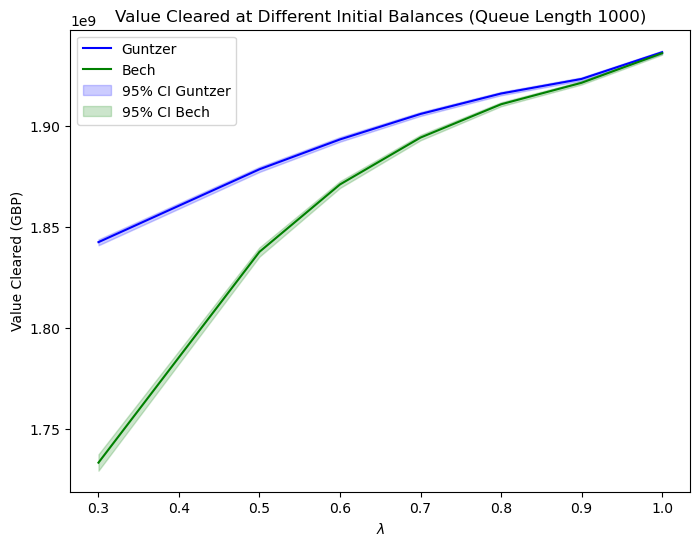

In [33]:
# Mean of value cleared for both algorithms
value_G = [np.mean(value_cleared_G_03_1000),np.mean(value_cleared_G_05_1000),np.mean(value_cleared_G_06_1000),\
            np.mean(value_cleared_G_07_1000),np.mean(value_cleared_G_08_1000),np.mean(value_cleared_G_09_1000),\
            np.mean(value_cleared_G_10_1000)]
value_B = [np.mean(value_cleared_B_03_1000),np.mean(value_cleared_B_05_1000),np.mean(value_cleared_B_06_1000),\
            np.mean(value_cleared_B_07_1000),np.mean(value_cleared_B_08_1000),np.mean(value_cleared_B_09_1000),\
            np.mean(value_cleared_B_10_1000)]

# Plot the change of value cleared for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, value_G, color = 'b', label = 'Guntzer')
plt.plot(lamb_list, value_B, color = 'g', label = 'Bech')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0] for x in ci_value_G_1000]),
                 np.array([x[1] for x in ci_value_G_1000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0] for x in ci_value_B_1000]),
                 np.array([x[1] for x in ci_value_B_1000]), color='g', alpha=0.2, label='95% CI Bech')

plt.xlabel('$\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Value Cleared (GBP)')
plt.title('Value Cleared at Different Initial Balances (Queue Length 1000)')
plt.legend()
plt.show()

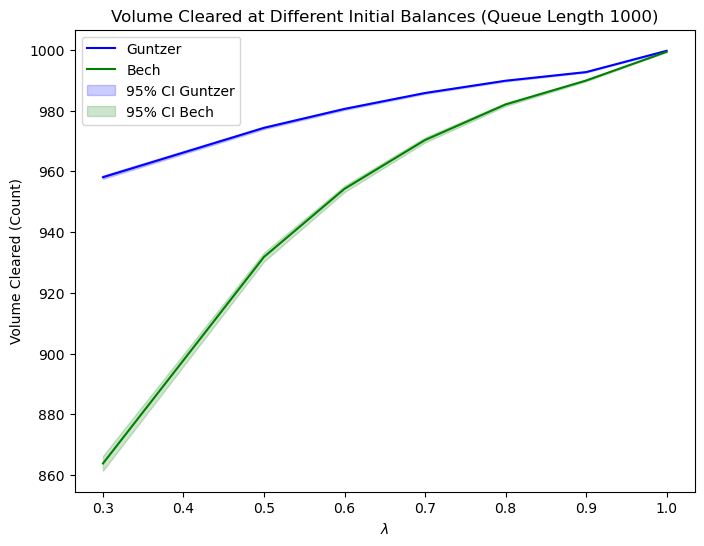

In [34]:
# Mean of volume cleared for both algorithms
volume_G = [np.mean(volume_cleared_G_03_1000),np.mean(volume_cleared_G_05_1000),np.mean(volume_cleared_G_06_1000),\
            np.mean(volume_cleared_G_07_1000),np.mean(volume_cleared_G_08_1000),np.mean(volume_cleared_G_09_1000),\
            np.mean(volume_cleared_G_10_1000)]
volume_B = [np.mean(volume_cleared_B_03_1000),np.mean(volume_cleared_B_05_1000),np.mean(volume_cleared_B_06_1000),\
            np.mean(volume_cleared_B_07_1000),np.mean(volume_cleared_B_08_1000),np.mean(volume_cleared_B_09_1000),\
            np.mean(volume_cleared_B_10_1000)]

# Plot the change of volume cleared for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, volume_G, color = 'b', label = 'Guntzer')
plt.plot(lamb_list, volume_B, color = 'g', label = 'Bech')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0] for x in ci_volume_G_1000]),
                 np.array([x[1] for x in ci_volume_G_1000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0] for x in ci_volume_B_1000]),
                 np.array([x[1] for x in ci_volume_B_1000]), color='g', alpha=0.2, label='95% CI Bech')

plt.xlabel('$\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Volume Cleared (Count)')
plt.title('Volume Cleared at Different Initial Balances (Queue Length 1000)')
plt.legend()
plt.show()  # display 

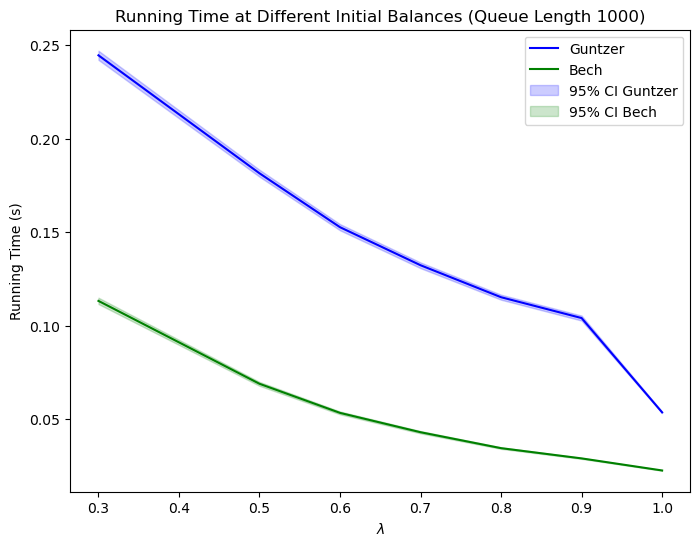

In [35]:
# Mean of running time for both algorithms
time_G = [np.mean(running_time_G_03_1000),np.mean(running_time_G_05_1000),np.mean(running_time_G_06_1000),\
            np.mean(running_time_G_07_1000),np.mean(running_time_G_08_1000),np.mean(running_time_G_09_1000),\
            np.mean(running_time_G_10_1000)]
time_B = [np.mean(running_time_B_03_1000),np.mean(running_time_B_05_1000),np.mean(running_time_B_06_1000),\
            np.mean(running_time_B_07_1000),np.mean(running_time_B_08_1000),np.mean(running_time_B_09_1000),\
            np.mean(running_time_B_10_1000)]

# Plot the change of running time for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, time_G, color = 'b', label = 'Guntzer')
plt.plot(lamb_list, time_B, color = 'g', label = 'Bech')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_G_1000]),
                 np.array([x[1] for x in ci_time_G_1000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_B_1000]),
                 np.array([x[1] for x in ci_time_B_1000]), color='g', alpha=0.2, label='95% CI Bech')

plt.xlabel('$\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Running Time (s)')
plt.title('Running Time at Different Initial Balances (Queue Length 1000)')
plt.legend()
plt.show()  # display 

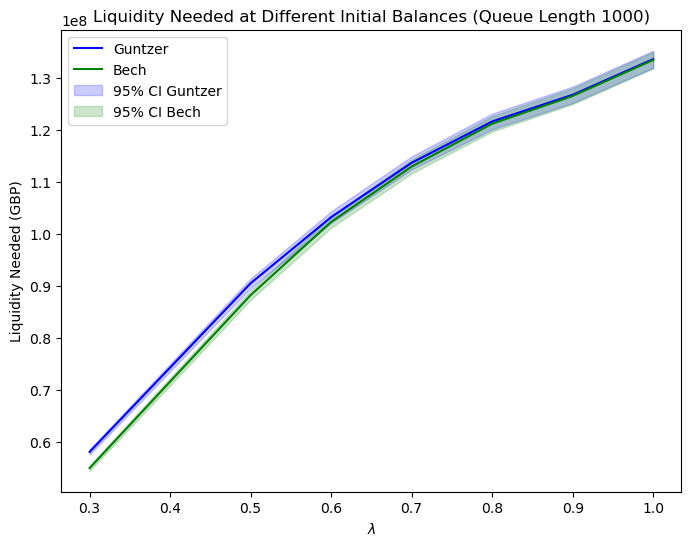

In [36]:
# Mean of liquidity needed for both algorithms
liquidity_G = [np.mean(liquidity_needed_G_03_1000),np.mean(liquidity_needed_G_05_1000),np.mean(liquidity_needed_G_06_1000),\
            np.mean(liquidity_needed_G_07_1000),np.mean(liquidity_needed_G_08_1000),np.mean(liquidity_needed_G_09_1000),\
            np.mean(liquidity_needed_G_10_1000)]
liquidity_B = [np.mean(liquidity_needed_B_03_1000),np.mean(liquidity_needed_B_05_1000),np.mean(liquidity_needed_B_06_1000),\
            np.mean(liquidity_needed_B_07_1000),np.mean(liquidity_needed_B_08_1000),np.mean(liquidity_needed_B_09_1000),\
            np.mean(liquidity_needed_B_10_1000)]
liquidity_G = [-1*x for x in liquidity_G]
liquidity_B = [-1*x for x in liquidity_B]

# Plot the change of liquidity needed for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, liquidity_G, color = 'b', label = 'Guntzer')
plt.plot(lamb_list, liquidity_B, color = 'g', label = 'Bech')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([-x[0] for x in ci_liquidity_G_1000]),
                 np.array([-x[1] for x in ci_liquidity_G_1000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([-x[0] for x in ci_liquidity_B_1000]),
                 np.array([-x[1] for x in ci_liquidity_B_1000]), color='g', alpha=0.2, label='95% CI Bech')

plt.xlabel('$\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Liquidity Needed (GBP)')
plt.title('Liquidity Needed at Different Initial Balances (Queue Length 1000)')
plt.legend()
plt.show()  # display 

In [37]:
# Function to format y-axis as percentage
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

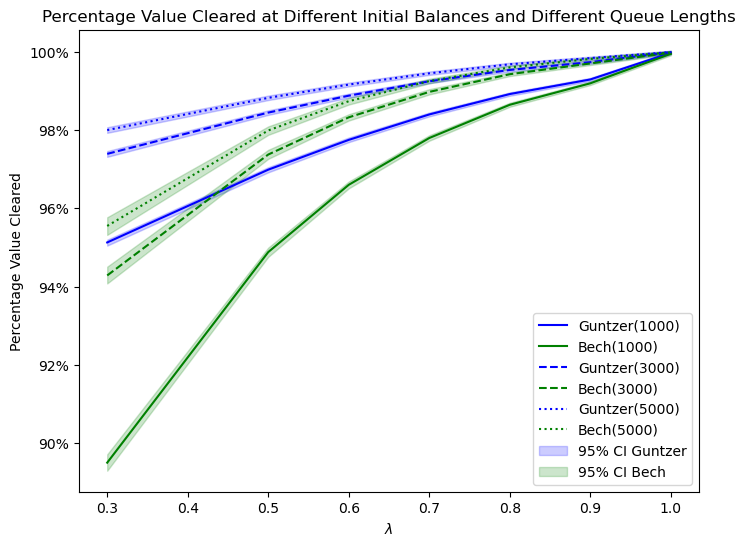

In [40]:
# Mean of percentage value cleared for both algorithms
value_G_1000 = [np.mean(np.array(value_cleared_G_03_1000)/np.array(value_queue_G_03_1000)),np.mean(np.array(value_cleared_G_05_1000)/np.array(value_queue_G_05_1000)),\
                np.mean(np.array(value_cleared_G_06_1000)/np.array(value_queue_G_06_1000)),np.mean(np.array(value_cleared_G_07_1000)/np.array(value_queue_G_07_1000)),\
                np.mean(np.array(value_cleared_G_08_1000)/np.array(value_queue_G_08_1000)),np.mean(np.array(value_cleared_G_09_1000)/np.array(value_queue_G_09_1000)),\
                np.mean(np.array(value_cleared_G_10_1000)/np.array(value_queue_G_10_1000))]
value_B_1000 = [np.mean(np.array(value_cleared_B_03_1000)/np.array(value_queue_B_03_1000)),np.mean(np.array(value_cleared_B_05_1000)/np.array(value_queue_B_05_1000)),\
                np.mean(np.array(value_cleared_B_06_1000)/np.array(value_queue_B_06_1000)),np.mean(np.array(value_cleared_B_07_1000)/np.array(value_queue_B_07_1000)),\
                np.mean(np.array(value_cleared_B_08_1000)/np.array(value_queue_B_08_1000)),np.mean(np.array(value_cleared_B_09_1000)/np.array(value_queue_B_09_1000)),\
                np.mean(np.array(value_cleared_B_10_1000)/np.array(value_queue_B_10_1000))]

value_G_5000 = [np.mean(np.array(value_cleared_G_03_5000)/np.array(value_queue_G_03_5000)),np.mean(np.array(value_cleared_G_05_5000)/np.array(value_queue_G_05_5000)),\
                np.mean(np.array(value_cleared_G_06_5000)/np.array(value_queue_G_06_5000)),np.mean(np.array(value_cleared_G_07_5000)/np.array(value_queue_G_07_5000)),\
                np.mean(np.array(value_cleared_G_08_5000)/np.array(value_queue_G_08_5000)),np.mean(np.array(value_cleared_G_09_5000)/np.array(value_queue_G_09_5000)),\
                np.mean(np.array(value_cleared_G_10_5000)/np.array(value_queue_G_10_5000))]
value_B_5000 = [np.mean(np.array(value_cleared_B_03_5000)/np.array(value_queue_B_03_5000)),np.mean(np.array(value_cleared_B_05_5000)/np.array(value_queue_B_05_5000)),\
                np.mean(np.array(value_cleared_B_06_5000)/np.array(value_queue_B_06_5000)),np.mean(np.array(value_cleared_B_07_5000)/np.array(value_queue_B_07_5000)),\
                np.mean(np.array(value_cleared_B_08_5000)/np.array(value_queue_B_08_5000)),np.mean(np.array(value_cleared_B_09_5000)/np.array(value_queue_B_09_5000)),\
                np.mean(np.array(value_cleared_B_10_5000)/np.array(value_queue_B_10_5000))]

value_G_3000 = [np.mean(np.array(value_cleared_G_03_3000)/np.array(value_queue_G_03_3000)),np.mean(np.array(value_cleared_G_05_3000)/np.array(value_queue_G_05_3000)),\
                np.mean(np.array(value_cleared_G_06_3000)/np.array(value_queue_G_06_3000)),np.mean(np.array(value_cleared_G_07_3000)/np.array(value_queue_G_07_3000)),\
                np.mean(np.array(value_cleared_G_08_3000)/np.array(value_queue_G_08_3000)),np.mean(np.array(value_cleared_G_09_3000)/np.array(value_queue_G_09_3000)),\
                np.mean(np.array(value_cleared_G_10_3000)/np.array(value_queue_G_10_3000))]
value_B_3000 = [np.mean(np.array(value_cleared_B_03_3000)/np.array(value_queue_B_03_3000)),np.mean(np.array(value_cleared_B_05_3000)/np.array(value_queue_B_05_3000)),\
                np.mean(np.array(value_cleared_B_06_3000)/np.array(value_queue_B_06_3000)),np.mean(np.array(value_cleared_B_07_3000)/np.array(value_queue_B_07_3000)),\
                np.mean(np.array(value_cleared_B_08_3000)/np.array(value_queue_B_08_3000)),np.mean(np.array(value_cleared_B_09_3000)/np.array(value_queue_B_09_3000)),\
                np.mean(np.array(value_cleared_B_10_3000)/np.array(value_queue_B_10_3000))]

# Plot the change of value cleared for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, value_G_1000, label = 'Guntzer(1000)', color = 'b')
plt.plot(lamb_list, value_B_1000, label = 'Bech(1000)', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_value_G_1000]),
                 np.array([x[1]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_value_G_1000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_value_B_1000]),
                 np.array([x[1]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_value_B_1000]), color='g', alpha=0.2)

plt.plot(lamb_list, value_G_3000, label = 'Guntzer(3000)', linestyle = '--', color = 'b')
plt.plot(lamb_list, value_B_3000, label = 'Bech(3000)', linestyle = '--', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_value_G_3000]),
                 np.array([x[1]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_value_G_3000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_value_B_3000]),
                 np.array([x[1]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_value_B_3000]), color='g', alpha=0.2)

plt.plot(lamb_list, value_G_5000, label = 'Guntzer(5000)', linestyle = ':', color = 'b')
plt.plot(lamb_list, value_B_5000, label = 'Bech(5000)', linestyle = ':', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_value_G_5000]),
                 np.array([x[1]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_value_G_5000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_value_B_5000]),
                 np.array([x[1]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_value_B_5000]), color='g', alpha=0.2, label='95% CI Bech')
plt.xlabel('$\lambda$')
plt.ylabel('Percentage Value Cleared')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Percentage Value Cleared at Different Initial Balances and Different Queue Lengths')
plt.legend()
plt.show()  # display 

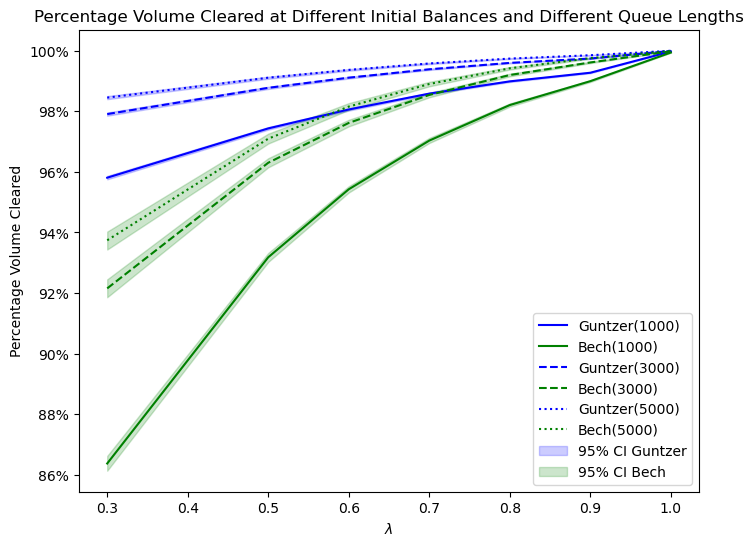

In [41]:
# Mean of percentage volume cleared for both algorithms
volume_G_1000 = [np.mean(np.array(volume_cleared_G_03_1000)/np.array(volume_queue_G_03_1000)),np.mean(np.array(volume_cleared_G_05_1000)/np.array(volume_queue_G_05_1000)),\
                np.mean(np.array(volume_cleared_G_06_1000)/np.array(volume_queue_G_06_1000)),np.mean(np.array(volume_cleared_G_07_1000)/np.array(volume_queue_G_07_1000)),\
                np.mean(np.array(volume_cleared_G_08_1000)/np.array(volume_queue_G_08_1000)),np.mean(np.array(volume_cleared_G_09_1000)/np.array(volume_queue_G_09_1000)),\
                np.mean(np.array(volume_cleared_G_10_1000)/np.array(volume_queue_G_10_1000))]
volume_B_1000 = [np.mean(np.array(volume_cleared_B_03_1000)/np.array(volume_queue_B_03_1000)),np.mean(np.array(volume_cleared_B_05_1000)/np.array(volume_queue_B_05_1000)),\
                np.mean(np.array(volume_cleared_B_06_1000)/np.array(volume_queue_B_06_1000)),np.mean(np.array(volume_cleared_B_07_1000)/np.array(volume_queue_B_07_1000)),\
                np.mean(np.array(volume_cleared_B_08_1000)/np.array(volume_queue_B_08_1000)),np.mean(np.array(volume_cleared_B_09_1000)/np.array(volume_queue_B_09_1000)),\
                np.mean(np.array(volume_cleared_B_10_1000)/np.array(volume_queue_B_10_1000))]

volume_G_5000 = [np.mean(np.array(volume_cleared_G_03_5000)/np.array(volume_queue_G_03_5000)),np.mean(np.array(volume_cleared_G_05_5000)/np.array(volume_queue_G_05_5000)),\
                np.mean(np.array(volume_cleared_G_06_5000)/np.array(volume_queue_G_06_5000)),np.mean(np.array(volume_cleared_G_07_5000)/np.array(volume_queue_G_07_5000)),\
                np.mean(np.array(volume_cleared_G_08_5000)/np.array(volume_queue_G_08_5000)),np.mean(np.array(volume_cleared_G_09_5000)/np.array(volume_queue_G_09_5000)),\
                np.mean(np.array(volume_cleared_G_10_5000)/np.array(volume_queue_G_10_5000))]
volume_B_5000 = [np.mean(np.array(volume_cleared_B_03_5000)/np.array(volume_queue_B_03_5000)),np.mean(np.array(volume_cleared_B_05_5000)/np.array(volume_queue_B_05_5000)),\
                np.mean(np.array(volume_cleared_B_06_5000)/np.array(volume_queue_B_06_5000)),np.mean(np.array(volume_cleared_B_07_5000)/np.array(volume_queue_B_07_5000)),\
                np.mean(np.array(volume_cleared_B_08_5000)/np.array(volume_queue_B_08_5000)),np.mean(np.array(volume_cleared_B_09_5000)/np.array(volume_queue_B_09_5000)),\
                np.mean(np.array(volume_cleared_B_10_5000)/np.array(volume_queue_B_10_5000))]

volume_G_3000 = [np.mean(np.array(volume_cleared_G_03_3000)/np.array(volume_queue_G_03_3000)),np.mean(np.array(volume_cleared_G_05_3000)/np.array(volume_queue_G_05_3000)),\
                np.mean(np.array(volume_cleared_G_06_3000)/np.array(volume_queue_G_06_3000)),np.mean(np.array(volume_cleared_G_07_3000)/np.array(volume_queue_G_07_3000)),\
                np.mean(np.array(volume_cleared_G_08_3000)/np.array(volume_queue_G_08_3000)),np.mean(np.array(volume_cleared_G_09_3000)/np.array(volume_queue_G_09_3000)),\
                np.mean(np.array(volume_cleared_G_10_3000)/np.array(volume_queue_G_10_3000))]
volume_B_3000 = [np.mean(np.array(volume_cleared_B_03_3000)/np.array(volume_queue_B_03_3000)),np.mean(np.array(volume_cleared_B_05_3000)/np.array(volume_queue_B_05_3000)),\
                np.mean(np.array(volume_cleared_B_06_3000)/np.array(volume_queue_B_06_3000)),np.mean(np.array(volume_cleared_B_07_3000)/np.array(volume_queue_B_07_3000)),\
                np.mean(np.array(volume_cleared_B_08_3000)/np.array(volume_queue_B_08_3000)),np.mean(np.array(volume_cleared_B_09_3000)/np.array(volume_queue_B_09_3000)),\
                np.mean(np.array(volume_cleared_B_10_3000)/np.array(volume_queue_B_10_3000))]

# Plot the change of volume cleared for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, volume_G_1000, label = 'Guntzer(1000)', color = 'b')
plt.plot(lamb_list, volume_B_1000, label = 'Bech(1000)', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(volume_queue_B_10_1000)) for x in ci_volume_G_1000]),
                 np.array([x[1]/np.mean(np.array(volume_queue_B_10_1000)) for x in ci_volume_G_1000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(volume_queue_B_10_1000)) for x in ci_volume_B_1000]),
                 np.array([x[1]/np.mean(np.array(volume_queue_B_10_1000)) for x in ci_volume_B_1000]), color='g', alpha=0.2)

plt.plot(lamb_list, volume_G_3000, label = 'Guntzer(3000)', linestyle = '--', color = 'b')
plt.plot(lamb_list, volume_B_3000, label = 'Bech(3000)', linestyle = '--', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(volume_queue_B_10_3000)) for x in ci_volume_G_3000]),
                 np.array([x[1]/np.mean(np.array(volume_queue_B_10_3000)) for x in ci_volume_G_3000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(volume_queue_B_10_3000)) for x in ci_volume_B_3000]),
                 np.array([x[1]/np.mean(np.array(volume_queue_B_10_3000)) for x in ci_volume_B_3000]), color='g', alpha=0.2)

plt.plot(lamb_list, volume_G_5000, label = 'Guntzer(5000)', linestyle = ':', color = 'b')
plt.plot(lamb_list, volume_B_5000, label = 'Bech(5000)', linestyle = ':', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(volume_queue_B_10_5000)) for x in ci_volume_G_5000]),
                 np.array([x[1]/np.mean(np.array(volume_queue_B_10_5000)) for x in ci_volume_G_5000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0]/np.mean(np.array(volume_queue_B_10_5000)) for x in ci_volume_B_5000]),
                 np.array([x[1]/np.mean(np.array(volume_queue_B_10_5000)) for x in ci_volume_B_5000]), color='g', alpha=0.2, label='95% CI Bech')
plt.xlabel('$\lambda$')
plt.ylabel('Percentage Volume Cleared')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Percentage Volume Cleared at Different Initial Balances and Different Queue Lengths')
plt.legend()
plt.show()  # display 

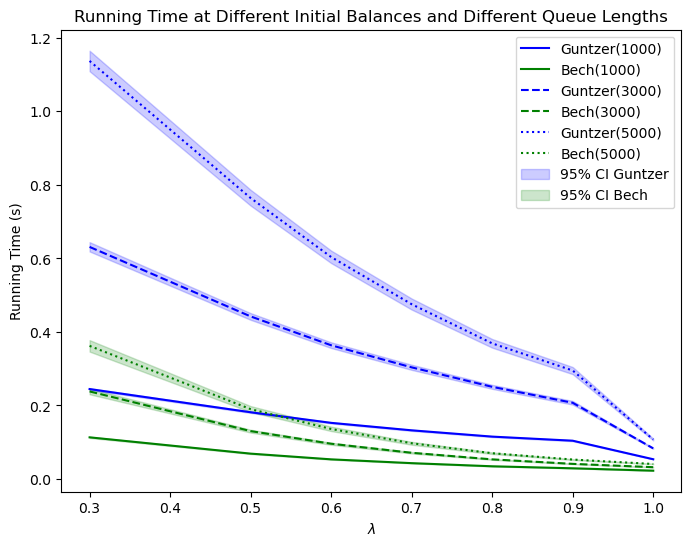

In [44]:
# Mean of running time for both algorithms
time_G_1000 = [np.mean(np.array(running_time_G_03_1000)),np.mean(np.array(running_time_G_05_1000)),\
                np.mean(np.array(running_time_G_06_1000)),np.mean(np.array(running_time_G_07_1000)),\
                np.mean(np.array(running_time_G_08_1000)),np.mean(np.array(running_time_G_09_1000)),\
                np.mean(np.array(running_time_G_10_1000))]
time_B_1000 = [np.mean(np.array(running_time_B_03_1000)),np.mean(np.array(running_time_B_05_1000)),\
                np.mean(np.array(running_time_B_06_1000)),np.mean(np.array(running_time_B_07_1000)),\
                np.mean(np.array(running_time_B_08_1000)),np.mean(np.array(running_time_B_09_1000)),\
                np.mean(np.array(running_time_B_10_1000))]

time_G_5000 = [np.mean(np.array(running_time_G_03_5000)),np.mean(np.array(running_time_G_05_5000)),\
                np.mean(np.array(running_time_G_06_5000)),np.mean(np.array(running_time_G_07_5000)),\
                np.mean(np.array(running_time_G_08_5000)),np.mean(np.array(running_time_G_09_5000)),\
                np.mean(np.array(running_time_G_10_5000))]
time_B_5000 = [np.mean(np.array(running_time_B_03_5000)),np.mean(np.array(running_time_B_05_5000)),\
                np.mean(np.array(running_time_B_06_5000)),np.mean(np.array(running_time_B_07_5000)),\
                np.mean(np.array(running_time_B_08_5000)),np.mean(np.array(running_time_B_09_5000)),\
                np.mean(np.array(running_time_B_10_5000))]

time_G_3000 = [np.mean(np.array(running_time_G_03_3000)),np.mean(np.array(running_time_G_05_3000)),\
                np.mean(np.array(running_time_G_06_3000)),np.mean(np.array(running_time_G_07_3000)),\
                np.mean(np.array(running_time_G_08_3000)),np.mean(np.array(running_time_G_09_3000)),\
                np.mean(np.array(running_time_G_10_3000))]
time_B_3000 = [np.mean(np.array(running_time_B_03_3000)),np.mean(np.array(running_time_B_05_3000)),\
                np.mean(np.array(running_time_B_06_3000)),np.mean(np.array(running_time_B_07_3000)),\
                np.mean(np.array(running_time_B_08_3000)),np.mean(np.array(running_time_B_09_3000)),\
                np.mean(np.array(running_time_B_10_3000))]

# Plot the change of running time for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, time_G_1000, label = 'Guntzer(1000)', color = 'b')
plt.plot(lamb_list, time_B_1000, label = 'Bech(1000)', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_G_1000]),
                 np.array([x[1] for x in ci_time_G_1000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_B_1000]),
                 np.array([x[1] for x in ci_time_B_1000]), color='g', alpha=0.2)

plt.plot(lamb_list, time_G_3000, label = 'Guntzer(3000)', linestyle = '--', color = 'b')
plt.plot(lamb_list, time_B_3000, label = 'Bech(3000)', linestyle = '--', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_G_3000]),
                 np.array([x[1] for x in ci_time_G_3000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_B_3000]),
                 np.array([x[1] for x in ci_time_B_3000]), color='g', alpha=0.2)

plt.plot(lamb_list, time_G_5000, label = 'Guntzer(5000)', linestyle = ':', color = 'b')
plt.plot(lamb_list, time_B_5000, label = 'Bech(5000)', linestyle = ':', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_G_5000]),
                 np.array([x[1] for x in ci_time_G_5000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([x[0] for x in ci_time_B_5000]),
                 np.array([x[1] for x in ci_time_B_5000]), color='g', alpha=0.2, label='95% CI Bech')
plt.xlabel('$\lambda$')
plt.ylabel('Running Time (s)')
plt.title('Running Time at Different Initial Balances and Different Queue Lengths')
plt.legend()
plt.show()  # display 

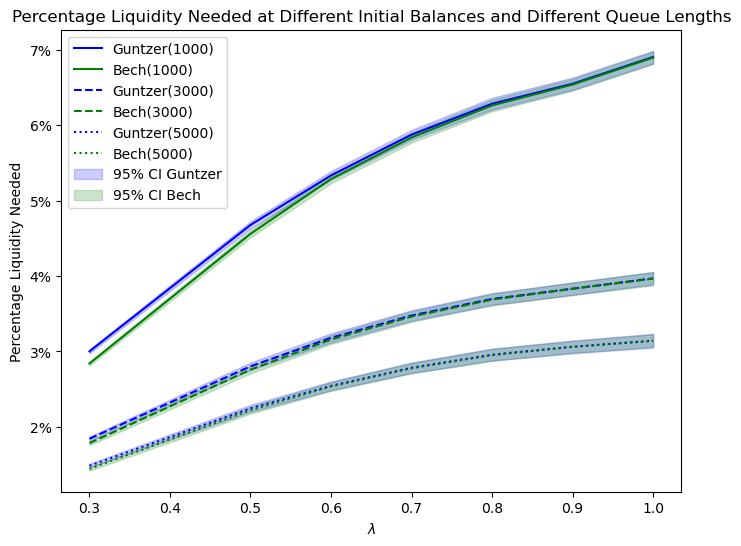

In [43]:
# Mean of liquidity needed for both algorithms
liquidity_G_1000 = [np.mean(np.array(liquidity_needed_G_03_1000)/np.array(value_queue_G_03_1000)),np.mean(np.array(liquidity_needed_G_05_1000)/np.array(value_queue_G_05_1000)),\
                np.mean(np.array(liquidity_needed_G_06_1000)/np.array(value_queue_G_06_1000)),np.mean(np.array(liquidity_needed_G_07_1000)/np.array(value_queue_G_07_1000)),\
                np.mean(np.array(liquidity_needed_G_08_1000)/np.array(value_queue_G_08_1000)),np.mean(np.array(liquidity_needed_G_09_1000)/np.array(value_queue_G_09_1000)),\
                np.mean(np.array(liquidity_needed_G_10_1000)/np.array(value_queue_G_10_1000))]
liquidity_B_1000 = [np.mean(np.array(liquidity_needed_B_03_1000)/np.array(value_queue_B_03_1000)),np.mean(np.array(liquidity_needed_B_05_1000)/np.array(value_queue_B_05_1000)),\
                np.mean(np.array(liquidity_needed_B_06_1000)/np.array(value_queue_B_06_1000)),np.mean(np.array(liquidity_needed_B_07_1000)/np.array(value_queue_B_07_1000)),\
                np.mean(np.array(liquidity_needed_B_08_1000)/np.array(value_queue_B_08_1000)),np.mean(np.array(liquidity_needed_B_09_1000)/np.array(value_queue_B_09_1000)),\
                np.mean(np.array(liquidity_needed_B_10_1000)/np.array(value_queue_B_10_1000))]

liquidity_G_5000 = [np.mean(np.array(liquidity_needed_G_03_5000)/np.array(value_queue_G_03_5000)),np.mean(np.array(liquidity_needed_G_05_5000)/np.array(value_queue_G_05_5000)),\
                np.mean(np.array(liquidity_needed_G_06_5000)/np.array(value_queue_G_06_5000)),np.mean(np.array(liquidity_needed_G_07_5000)/np.array(value_queue_G_07_5000)),\
                np.mean(np.array(liquidity_needed_G_08_5000)/np.array(value_queue_G_08_5000)),np.mean(np.array(liquidity_needed_G_09_5000)/np.array(value_queue_G_09_5000)),\
                np.mean(np.array(liquidity_needed_G_10_5000)/np.array(value_queue_G_10_5000))]
liquidity_B_5000 = [np.mean(np.array(liquidity_needed_B_03_5000)/np.array(value_queue_B_03_5000)),np.mean(np.array(liquidity_needed_B_05_5000)/np.array(value_queue_B_05_5000)),\
                np.mean(np.array(liquidity_needed_B_06_5000)/np.array(value_queue_B_06_5000)),np.mean(np.array(liquidity_needed_B_07_5000)/np.array(value_queue_B_07_5000)),\
                np.mean(np.array(liquidity_needed_B_08_5000)/np.array(value_queue_B_08_5000)),np.mean(np.array(liquidity_needed_B_09_5000)/np.array(value_queue_B_09_5000)),\
                np.mean(np.array(liquidity_needed_B_10_5000)/np.array(value_queue_B_10_5000))]

liquidity_G_3000 = [np.mean(np.array(liquidity_needed_G_03_3000)/np.array(value_queue_G_03_3000)),np.mean(np.array(liquidity_needed_G_05_3000)/np.array(value_queue_G_05_3000)),\
                np.mean(np.array(liquidity_needed_G_06_3000)/np.array(value_queue_G_06_3000)),np.mean(np.array(liquidity_needed_G_07_3000)/np.array(value_queue_G_07_3000)),\
                np.mean(np.array(liquidity_needed_G_08_3000)/np.array(value_queue_G_08_3000)),np.mean(np.array(liquidity_needed_G_09_3000)/np.array(value_queue_G_09_3000)),\
                np.mean(np.array(liquidity_needed_G_10_3000)/np.array(value_queue_G_10_3000))]
liquidity_B_3000 = [np.mean(np.array(liquidity_needed_B_03_3000)/np.array(value_queue_B_03_3000)),np.mean(np.array(liquidity_needed_B_05_3000)/np.array(value_queue_B_05_3000)),\
                np.mean(np.array(liquidity_needed_B_06_3000)/np.array(value_queue_B_06_3000)),np.mean(np.array(liquidity_needed_B_07_3000)/np.array(value_queue_B_07_3000)),\
                np.mean(np.array(liquidity_needed_B_08_3000)/np.array(value_queue_B_08_3000)),np.mean(np.array(liquidity_needed_B_09_3000)/np.array(value_queue_B_09_3000)),\
                np.mean(np.array(liquidity_needed_B_10_3000)/np.array(value_queue_B_10_3000))]

liquidity_G_1000 = [-1*x for x in liquidity_G_1000]
liquidity_B_1000 = [-1*x for x in liquidity_B_1000]
liquidity_G_3000 = [-1*x for x in liquidity_G_3000]
liquidity_B_3000 = [-1*x for x in liquidity_B_3000]
liquidity_G_5000 = [-1*x for x in liquidity_G_5000]
liquidity_B_5000 = [-1*x for x in liquidity_B_5000]

# Plot the change of liquidity needed for both algorithms under different initial values
fig = plt.figure(figsize=(8,6))
plt.plot(lamb_list, liquidity_G_1000, label = 'Guntzer(1000)', color = 'b')
plt.plot(lamb_list, liquidity_B_1000, label = 'Bech(1000)', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([-x[0]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_liquidity_G_1000]),
                 np.array([-x[1]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_liquidity_G_1000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([-x[0]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_liquidity_B_1000]),
                 np.array([-x[1]/np.mean(np.array(value_queue_B_10_1000)) for x in ci_liquidity_B_1000]), color='g', alpha=0.2)

plt.plot(lamb_list, liquidity_G_3000, label = 'Guntzer(3000)', linestyle = '--', color = 'b')
plt.plot(lamb_list, liquidity_B_3000, label = 'Bech(3000)', linestyle = '--', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([-x[0]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_liquidity_G_3000]),
                 np.array([-x[1]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_liquidity_G_3000]), color='b', alpha=0.2)
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([-x[0]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_liquidity_B_3000]),
                 np.array([-x[1]/np.mean(np.array(value_queue_B_10_3000)) for x in ci_liquidity_B_3000]), color='g', alpha=0.2)

plt.plot(lamb_list, liquidity_G_5000, label = 'Guntzer(5000)', linestyle = ':', color = 'b')
plt.plot(lamb_list, liquidity_B_5000, label = 'Bech(5000)', linestyle = ':', color = 'g')
# Fill the confidence interval for Guntzer
plt.fill_between(lamb_list, np.array([-x[0]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_liquidity_G_5000]),
                 np.array([-x[1]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_liquidity_G_5000]), color='b', alpha=0.2, label='95% CI Guntzer')
# Fill the confidence interval for Bech
plt.fill_between(lamb_list, np.array([-x[0]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_liquidity_B_5000]),
                 np.array([-x[1]/np.mean(np.array(value_queue_B_10_5000)) for x in ci_liquidity_B_5000]), color='g', alpha=0.2, label='95% CI Bech')
plt.xlabel('$\lambda$')
plt.ylabel('Percentage Liquidity Needed')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('Percentage Liquidity Needed at Different Initial Balances and Different Queue Lengths')
plt.legend()
plt.show()  # display 